## NHL Game Prediction Model
__By: Nathan Anderson__<br>
***

## `Table of Contents`
- [Abstract](#abstract)
- [Preprocessing](#preprocessing)
  - [Notebook Setup](#notebook-setup)
  - [Importing Data](#importing-data)
  - [Data Cleaning](#data-cleaning)
  - [Feature Engineering](#feature-engineering)
  - [Slicing Data](#slicing-data)
  - [Home Team DataFrame](#home-team-dataframe)
  - [Away Team DataFrame](#away-team-dataframe)
  - [Home & Away Joined DataFrame](#home--away-joined-dataframe)
  - [DataFrame for Machine Learning](#dataframe-for-machine-learning)
  - [Principal Component Analysis](#principal-component-analysis)
- [Models](#models)
  - [Model Goals](#model-goals)
  - [Logistic Classification](#logistic-classification)
  - [Random Forest](#random-forest)
  - [Neural Network - DENSE](#neural-network---dense)
  - [Neural Network - DENSE Final Model](#neural-network---dense-final-model)
  - [Neural Network - PCA](#neural-network---pca)
  - [Neural Network - PCA Final Model](#neural-network---pca-final-model)
  - [Prediction - DENSE DataFrame](#predictions---dense-dataframe)
  - [Prediction - DENSE Model](#predictions---dense-model)
  - [Prediction - PCA DataFrame](#predictions---pca-dataframe)
  - [Prediction - PCA Model](#predictions---pca-model)
- [Discussion](#discussion)
- [Conclusion](#conclusion)
<br>

***

## `Abstract`

This notebook contains multiple maching learning algorithms but the main focus was the use of neural network in an attempt to predict the outcomes of National Hockey League (NHL) games.<br> 
<br>
The models were trained on game data from 2020 to the present but there was multiple other datasets created that were required to complete the training and predictions of the 2022-23 season. The main dataset used was the game level data which required a lot of preprocessing. A new dataset was created from the original game level dataset to have all the desired features for each game on one row as opposed to multiple rows, which would not have been compatible to train the model. Also, other feature columns were created from the data to be used in the modeling. <br>
The dataset required for the 2022-23 season that was used to make predictions also required extensive preprocessing as it also needed to be in the exact same format as the data used to originally train the model. In addition, I also utilized Principal Component Analysis to reduce the size of the dataset while still maintaining 99% of the information. This dataset was also used to train a model.<br>
<br>
I've included two models as a baseline, Logistic Classification and Random Forests, to measure the performance of the neural networks. I've tested many different architectures of neural networks and two have shown some very promising results. In my research, most models online state that they acheive around 60-65% accuracy and I have made multiple models that can slightly exceed this result now.<br>
<br>

## `Preprocessing`

### `Notebook Setup`

Importing the necessary python coding libraries that will be used throughout the notebook and setting display options to ensure all rows and columns are displayed when desired.

In [4]:
# Import python coding libraries
import urllib.request
import json
import pandas as pd
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import math
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, SimpleRNN, LSTM, GRU, Reshape, Activation, Bidirectional
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

# Seeting random seeds to duplicate results
np.random.seed(2)
tf.random.set_seed(2)

# Notebook display options
desired_width = 320
pd.set_option('display.width', desired_width)
np.set_printoptions(linewidth = desired_width)
pd.set_option('display.max_columns', 300)

2023-02-22 16:21:23.967204: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### `Importing Data`

* Importing the most recent dataset from __www.moneypuck.com__ and saving it into a format that can be used for further python analysis.

* __Data Source: https://moneypuck.com/data.htm__

* Game data explanation:
  * The dataset contains 10 rows for every game played that are uniquely identified by the _gameId_ column.
    * All 10 rows contain the same game level data in the first 10 columns but the remaining columns are metrics corresponding only to the _team_ column.
    * 5 rows are for the _team_ and the other 5 rows are for the _opposingTeam_.
    * There is 5 rows per team because the data is also separated by _situation_.
      * _situation_ includes:
        * 5on5
        * 4on5
        * 5on4
        * other
        * all
      * The _all_ data is the only data that is used for training the algorithm.

In [5]:
# Function to do an api call and return raw data from an url
def api_call(url: str):
    """Returns the result of an API call."""
   
    user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'
    headers= {'User-Agent': user_agent,} 

    request = urllib.request.Request(url, None, headers)
    response = urllib.request.urlopen(request)
    data = response.read()
    rawData = pd.read_csv(io.StringIO(data.decode('utf-8')))
    
    return rawData

In [6]:
# Importing the most recent data using the function above
url = 'https://moneypuck.com/moneypuck/playerData/careers/gameByGame/all_teams.csv'
rawData = api_call(url)
rawData.head(10)

,team,season,name,gameId,playerTeam,opposingTeam,home_or_away,gameDate,position,situation,xGoalsPercentage,corsiPercentage,fenwickPercentage,iceTime,xOnGoalFor,xGoalsFor,xReboundsFor,xFreezeFor,xPlayStoppedFor,xPlayContinuedInZoneFor,xPlayContinuedOutsideZoneFor,flurryAdjustedxGoalsFor,scoreVenueAdjustedxGoalsFor,flurryScoreVenueAdjustedxGoalsFor,shotsOnGoalFor,missedShotsFor,blockedShotAttemptsFor,shotAttemptsFor,goalsFor,reboundsFor,reboundGoalsFor,freezeFor,playStoppedFor,playContinuedInZoneFor,playContinuedOutsideZoneFor,savedShotsOnGoalFor,savedUnblockedShotAttemptsFor,penaltiesFor,penalityMinutesFor,faceOffsWonFor,hitsFor,takeawaysFor,giveawaysFor,lowDangerShotsFor,mediumDangerShotsFor,highDangerShotsFor,lowDangerxGoalsFor,mediumDangerxGoalsFor,highDangerxGoalsFor,lowDangerGoalsFor,mediumDangerGoalsFor,highDangerGoalsFor,scoreAdjustedShotsAttemptsFor,unblockedShotAttemptsFor,scoreAdjustedUnblockedShotAttemptsFor,dZoneGiveawaysFor,xGoalsFromxReboundsOfShotsFor,xGoalsFromActualReboundsOfShotsFor,reboundxGoalsFor,totalShotCreditFor,scoreAdjustedTotalShotCreditFor,scoreFlurryAdjustedTotalShotCreditFor,xOnGoalAgainst,xGoalsAgainst,xReboundsAgainst,xFreezeAgainst,xPlayStoppedAgainst,xPlayContinuedInZoneAgainst,xPlayContinuedOutsideZoneAgainst,flurryAdjustedxGoalsAgainst,scoreVenueAdjustedxGoalsAgainst,flurryScoreVenueAdjustedxGoalsAgainst,shotsOnGoalAgainst,missedShotsAgainst,blockedShotAttemptsAgainst,shotAttemptsAgainst,goalsAgainst,reboundsAgainst,reboundGoalsAgainst,freezeAgainst,playStoppedAgainst,playContinuedInZoneAgainst,playContinuedOutsideZoneAgainst,savedShotsOnGoalAgainst,savedUnblockedShotAttemptsAgainst,penaltiesAgainst,penalityMinutesAgainst,faceOffsWonAgainst,hitsAgainst,takeawaysAgainst,giveawaysAgainst,lowDangerShotsAgainst,mediumDangerShotsAgainst,highDangerShotsAgainst,lowDangerxGoalsAgainst,mediumDangerxGoalsAgainst,highDangerxGoalsAgainst,lowDangerGoalsAgainst,mediumDangerGoalsAgainst,highDangerGoalsAgainst,scoreAdjustedShotsAttemptsAgainst,unblockedShotAttemptsAgainst,scoreAdjustedUnblockedShotAttemptsAgainst,dZoneGiveawaysAgainst,xGoalsFromxReboundsOfShotsAgainst,xGoalsFromActualReboundsOfShotsAgainst,reboundxGoalsAgainst,totalShotCreditAgainst,scoreAdjustedTotalShotCreditAgainst,scoreFlurryAdjustedTotalShotCreditAgainst,playoffGame
0,NYR,2008,NYR,2008020001,NYR,T.B,AWAY,20081004,Team Level,other,0.0000,0.0000,0.0000,42.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.689,0.019,0.069,0.164,0.020,0.521,0.207,0.019,0.019,0.019,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.019,0.000,0.000,0.0,0.0,0.0,1.000,1.0,1.000,0.0,0.017,0.000,0.000,0.037,0.037,0.037,0
1,NYR,2008,NYR,2008020001,NYR,T.B,AWAY,20081004,Team Level,all,0.4596,0.6408,0.6310,3600.0,37.733,2.287,2.842,8.155,1.134,22.530,16.054,2.249,2.396,2.357,41.0,12.0,13.0,66.0,2.0,1.0,0.0,14.0,2.0,18.0,16.0,39.0,51.0,4.0,8.0,30.0,16.0,19.0,8.0,44.0,8.0,1.0,1.040,0.811,0.435,1.0,0.0,1.0,68.292,53.0,54.697,4.0,0.641,0.014,0.029,2.899,3.030,2.980,22.880,2.689,1.780,4.436,0.639,12.626,8.830,2.524,2.607,2.450,21.0,10.0,6.0,37.0,1.0,1.0,0.0,5.0,1.0,8.0,15.0,20.0,30.0,7.0,14.0,32.0,17.0,11.0,7.0,16.0,12.0,3.0,0.599,1.278,0.811,1.0,0.0,0.0,36.140,31.0,30.369,5.0,0.396,0.168,0.168,2.917,2.833,2.714,0
2,NYR,2008,NYR,2008020001,NYR,T.B,AWAY,20081004,Team Level,5on5,0.4857,0.6429,0.6364,2283.0,24.802,1.693,1.724,5.513,0.739,14.650,10.681,1.656,1.803,1.764,28.0,7.0,10.0,45.0,1.0,0.0,0.0,10.0,1.0,14.0,9.0,27.0,34.0,3.0,6.0,19.0,13.0,13.0,7.0,27.0,8.0,0.0,0.882,0.811,0.000,1.0,0.0,0.0,47.292,35.0,36.697,4.0,0.355,0.000,0.000,2.048,2.180,2.130,14.729,1.793,1.117,3.001,0.406,7.737,5.946,1.633,1.711,1.559,11.0,9.0,5.0,25.0,1.0,1.0,0.0,4.0,1.0,4.0,9.0,10.0,19.0,7.0,14.0,18.0,13.0,9.0,5.0,12.0,6.0,2.0,0.498,0.689,0.606,1.0,0.0,0.0,24.140,20.0,19.

### `Data Cleaning`

* Fixing team acronym issue. 
  * Five teams had multiple acronyms from years past.

In [5]:
def team_acronyms(df):
    """Function to fix duplicate acronyms for same team."""

    # Replacing duplicate team name acronyms
    df['opposingTeam'].replace({'S.J': 'SJS'}, inplace = True)
    df['opposingTeam'].replace({'N.J': 'NJD'}, inplace = True)
    df['opposingTeam'].replace({'T.B': 'TBL'}, inplace = True)
    df['opposingTeam'].replace({'L.A': 'LAK'}, inplace = True)
    df['opposingTeam'].replace({'ATL': 'WPG'}, inplace = True)

    df['team'].replace({'S.J': 'SJS'}, inplace = True)
    df['team'].replace({'N.J': 'NJD'}, inplace = True)
    df['team'].replace({'T.B': 'TBL'}, inplace = True)
    df['team'].replace({'L.A': 'LAK'}, inplace = True)
    df['team'].replace({'ATL': 'WPG'}, inplace = True)

    df['name'].replace({'S.J': 'SJS'}, inplace = True)
    df['name'].replace({'N.J': 'NJD'}, inplace = True)
    df['name'].replace({'T.B': 'TBL'}, inplace = True)
    df['name'].replace({'L.A': 'LAK'}, inplace = True)
    df['name'].replace({'ATL': 'WPG'}, inplace = True)

    df['playerTeam'].replace({'S.J': 'SJS'}, inplace = True)
    df['playerTeam'].replace({'N.J': 'NJD'}, inplace = True)
    df['playerTeam'].replace({'T.B': 'TBL'}, inplace = True)
    df['playerTeam'].replace({'L.A': 'LAK'}, inplace = True)
    df['playerTeam'].replace({'ATL': 'WPG'}, inplace = True)
    
    cleanData = df
    
    return cleanData

In [6]:
# Cleaning the rawData using the function above
cleanData = team_acronyms(rawData)
cleanData.head()

,team,season,name,gameId,playerTeam,opposingTeam,home_or_away,gameDate,position,situation,xGoalsPercentage,corsiPercentage,fenwickPercentage,iceTime,xOnGoalFor,xGoalsFor,xReboundsFor,xFreezeFor,xPlayStoppedFor,xPlayContinuedInZoneFor,xPlayContinuedOutsideZoneFor,flurryAdjustedxGoalsFor,scoreVenueAdjustedxGoalsFor,flurryScoreVenueAdjustedxGoalsFor,shotsOnGoalFor,missedShotsFor,blockedShotAttemptsFor,shotAttemptsFor,goalsFor,reboundsFor,reboundGoalsFor,freezeFor,playStoppedFor,playContinuedInZoneFor,playContinuedOutsideZoneFor,savedShotsOnGoalFor,savedUnblockedShotAttemptsFor,penaltiesFor,penalityMinutesFor,faceOffsWonFor,hitsFor,takeawaysFor,giveawaysFor,lowDangerShotsFor,mediumDangerShotsFor,highDangerShotsFor,lowDangerxGoalsFor,mediumDangerxGoalsFor,highDangerxGoalsFor,lowDangerGoalsFor,mediumDangerGoalsFor,highDangerGoalsFor,scoreAdjustedShotsAttemptsFor,unblockedShotAttemptsFor,scoreAdjustedUnblockedShotAttemptsFor,dZoneGiveawaysFor,xGoalsFromxReboundsOfShotsFor,xGoalsFromActualReboundsOfShotsFor,reboundxGoalsFor,totalShotCreditFor,scoreAdjustedTotalShotCreditFor,scoreFlurryAdjustedTotalShotCreditFor,xOnGoalAgainst,xGoalsAgainst,xReboundsAgainst,xFreezeAgainst,xPlayStoppedAgainst,xPlayContinuedInZoneAgainst,xPlayContinuedOutsideZoneAgainst,flurryAdjustedxGoalsAgainst,scoreVenueAdjustedxGoalsAgainst,flurryScoreVenueAdjustedxGoalsAgainst,shotsOnGoalAgainst,missedShotsAgainst,blockedShotAttemptsAgainst,shotAttemptsAgainst,goalsAgainst,reboundsAgainst,reboundGoalsAgainst,freezeAgainst,playStoppedAgainst,playContinuedInZoneAgainst,playContinuedOutsideZoneAgainst,savedShotsOnGoalAgainst,savedUnblockedShotAttemptsAgainst,penaltiesAgainst,penalityMinutesAgainst,faceOffsWonAgainst,hitsAgainst,takeawaysAgainst,giveawaysAgainst,lowDangerShotsAgainst,mediumDangerShotsAgainst,highDangerShotsAgainst,lowDangerxGoalsAgainst,mediumDangerxGoalsAgainst,highDangerxGoalsAgainst,lowDangerGoalsAgainst,mediumDangerGoalsAgainst,highDangerGoalsAgainst,scoreAdjustedShotsAttemptsAgainst,unblockedShotAttemptsAgainst,scoreAdjustedUnblockedShotAttemptsAgainst,dZoneGiveawaysAgainst,xGoalsFromxReboundsOfShotsAgainst,xGoalsFromActualReboundsOfShotsAgainst,reboundxGoalsAgainst,totalShotCreditAgainst,scoreAdjustedTotalShotCreditAgainst,scoreFlurryAdjustedTotalShotCreditAgainst,playoffGame
0,NYR,2008,NYR,2008020001,NYR,TBL,AWAY,20081004,Team Level,other,0.0000,0.0000,0.0000,42.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.689,0.019,0.069,0.164,0.020,0.521,0.207,0.019,0.019,0.019,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.019,0.000,0.000,0.0,0.0,0.0,1.00,1.0,1.000,0.0,0.017,0.000,0.000,0.037,0.037,0.037,0
1,NYR,2008,NYR,2008020001,NYR,TBL,AWAY,20081004,Team Level,all,0.4596,0.6408,0.6310,3600.0,37.733,2.287,2.842,8.155,1.134,22.530,16.054,2.249,2.396,2.357,41.0,12.0,13.0,66.0,2.0,1.0,0.0,14.0,2.0,18.0,16.0,39.0,51.0,4.0,8.0,30.0,16.0,19.0,8.0,44.0,8.0,1.0,1.040,0.811,0.435,1.0,0.0,1.0,68.292,53.0,54.697,4.0,0.641,0.014,0.029,2.899,3.030,2.980,22.880,2.689,1.780,4.436,0.639,12.626,8.830,2.524,2.607,2.450,21.0,10.0,6.0,37.0,1.0,1.0,0.0,5.0,1.0,8.0,15.0,20.0,30.0,7.0,14.0,32.0,17.0,11.0,7.0,16.0,12.0,3.0,0.599,1.278,0.811,1.0,0.0,0.0,36.14,31.0,30.369,5.0,0.396,0.168,0.168,2.917,2.833,2.714,0
2,NYR,2008,NYR,2008020001,NYR,TBL,AWAY,20081004,Team Level,5on5,0.4857,0.6429,0.6364,2283.0,24.802,1.693,1.724,5.513,0.739,14.650,10.681,1.656,1.803,1.764,28.0,7.0,10.0,45.0,1.0,0.0,0.0,10.0,1.0,14.0,9.0,27.0,34.0,3.0,6.0,19.0,13.0,13.0,7.0,27.0,8.0,0.0,0.882,0.811,0.000,1.0,0.0,0.0,47.292,35.0,36.697,4.0,0.355,0.000,0.000,2.048,2.180,2.130,14.729,1.793,1.117,3.001,0.406,7.737,5.946,1.633,1.711,1.559,11.0,9.0,5.0,25.0,1.0,1.0,0.0,4.0,1.0,4.0,9.0,10.0,19.0,7.0,14.0,18.0,13.0,9.0,5.0,12.0,6.0,2.0,0.498,0.689,0.606,1.0,0.0,0.0,24.14,20.0,19.369

### `Feature Engineering`

* Creating new feature columns from the data to be used for further analysis.
* Changing categorical columns to be numerical so they are in the proper format within the algorithm.
* Slicing the data based on different seasons or game situations.

In [7]:
# Define function to add feature columns
def feat_eng(df):

    # Adding columns
    shootout_game = np.where((df['situation'] == 'all') & (df['goalsFor'] == df['goalsAgainst']), 1, 0)
    df.insert(loc = 6, column = 'Shootout Game', value = shootout_game)

    ot_game = np.where(df['iceTime'] > 3600.0, 1, 0)
    df.insert(loc = 7, column = 'OT Game', value = ot_game)

    win = np.where(df['goalsFor'] > df['goalsAgainst'], 1, 0)
    df.insert(loc = 8, column = 'Win', value = win)

    loss = np.where((df['OT Game'] == 0) & (df['goalsFor'] < df['goalsAgainst']), 1, 0)
    df.insert(loc = 9, column = 'Loss', value = loss)

    # ot_loss = np.where((df['OT Game'] == 1) & (df['goalsFor'] < df['goalsAgainst']), 1, 0)
    # df.insert(loc = 10, column = 'OT Loss', value = ot_loss)
    
    # Save percentage
    save_percentage = (df['shotsOnGoalAgainst'] - df['goalsAgainst']) / df['shotsOnGoalAgainst']
    df.insert(loc = 10, column = 'SavePercentage', value = save_percentage)

    # Adding date columns
    df['gameDate'] = pd.to_datetime(df['gameDate'],format='%Y%m%d')
    df['year'] = pd.DatetimeIndex(df['gameDate']).year
    df['month'] = pd.DatetimeIndex(df['gameDate']).month
    df['day'] = pd.DatetimeIndex(df['gameDate']).day

    # Changing categorical columns to be numerical
    le = preprocessing.LabelEncoder()
    df['home_or_away#'] = le.fit_transform(df['home_or_away'])
    df['team#'] = le.fit_transform(df['team'])
    df['opposingTeam#'] = le.fit_transform(df['opposingTeam'])

    return df

In [8]:
# Feature Engineering using the cleanData and the function above
df = feat_eng(cleanData)
df = df.sort_values('gameId')
df.head()

,team,season,name,gameId,playerTeam,opposingTeam,Shootout Game,OT Game,Win,Loss,SavePercentage,home_or_away,gameDate,position,situation,xGoalsPercentage,corsiPercentage,fenwickPercentage,iceTime,xOnGoalFor,xGoalsFor,xReboundsFor,xFreezeFor,xPlayStoppedFor,xPlayContinuedInZoneFor,xPlayContinuedOutsideZoneFor,flurryAdjustedxGoalsFor,scoreVenueAdjustedxGoalsFor,flurryScoreVenueAdjustedxGoalsFor,shotsOnGoalFor,missedShotsFor,blockedShotAttemptsFor,shotAttemptsFor,goalsFor,reboundsFor,reboundGoalsFor,freezeFor,playStoppedFor,playContinuedInZoneFor,playContinuedOutsideZoneFor,savedShotsOnGoalFor,savedUnblockedShotAttemptsFor,penaltiesFor,penalityMinutesFor,faceOffsWonFor,hitsFor,takeawaysFor,giveawaysFor,lowDangerShotsFor,mediumDangerShotsFor,highDangerShotsFor,lowDangerxGoalsFor,mediumDangerxGoalsFor,highDangerxGoalsFor,lowDangerGoalsFor,mediumDangerGoalsFor,highDangerGoalsFor,scoreAdjustedShotsAttemptsFor,unblockedShotAttemptsFor,scoreAdjustedUnblockedShotAttemptsFor,dZoneGiveawaysFor,xGoalsFromxReboundsOfShotsFor,xGoalsFromActualReboundsOfShotsFor,reboundxGoalsFor,totalShotCreditFor,scoreAdjustedTotalShotCreditFor,scoreFlurryAdjustedTotalShotCreditFor,xOnGoalAgainst,xGoalsAgainst,xReboundsAgainst,xFreezeAgainst,xPlayStoppedAgainst,xPlayContinuedInZoneAgainst,xPlayContinuedOutsideZoneAgainst,flurryAdjustedxGoalsAgainst,scoreVenueAdjustedxGoalsAgainst,flurryScoreVenueAdjustedxGoalsAgainst,shotsOnGoalAgainst,missedShotsAgainst,blockedShotAttemptsAgainst,shotAttemptsAgainst,goalsAgainst,reboundsAgainst,reboundGoalsAgainst,freezeAgainst,playStoppedAgainst,playContinuedInZoneAgainst,playContinuedOutsideZoneAgainst,savedShotsOnGoalAgainst,savedUnblockedShotAttemptsAgainst,penaltiesAgainst,penalityMinutesAgainst,faceOffsWonAgainst,hitsAgainst,takeawaysAgainst,giveawaysAgainst,lowDangerShotsAgainst,mediumDangerShotsAgainst,highDangerShotsAgainst,lowDangerxGoalsAgainst,mediumDangerxGoalsAgainst,highDangerxGoalsAgainst,lowDangerGoalsAgainst,mediumDangerGoalsAgainst,highDangerGoalsAgainst,scoreAdjustedShotsAttemptsAgainst,unblockedShotAttemptsAgainst,scoreAdjustedUnblockedShotAttemptsAgainst,dZoneGiveawaysAgainst,xGoalsFromxReboundsOfShotsAgainst,xGoalsFromActualReboundsOfShotsAgainst,reboundxGoalsAgainst,totalShotCreditAgainst,scoreAdjustedTotalShotCreditAgainst,scoreFlurryAdjustedTotalShotCreditAgainst,playoffGame,year,month,day,home_or_away#,team#,opposingTeam#
0,NYR,2008,NYR,2008020001,NYR,TBL,0,0,0,0,1.000000,AWAY,2008-10-04,Team Level,other,0.0000,0.0000,0.0000,42.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.0,0.00,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.689,0.019,0.069,0.164,0.020,0.521,0.207,0.019,0.019,0.019,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.019,0.000,0.000,0.0,0.0,0.0,1.000,1.0,1.000,0.0,0.017,0.000,0.000,0.037,0.037,0.037,0,2008,10,4,0,19,26
40497,TBL,2008,TBL,2008020001,TBL,NYR,0,0,0,0,0.964286,HOME,2008-10-04,Team Level,5on5,0.5143,0.3571,0.3636,2283.0,14.729,1.793,1.117,3.001,0.406,7.737,5.946,1.633,1.711,1.559,11.0,9.0,5.0,25.0,1.0,1.0,0.0,4.0,1.0,4.0,9.0,10.0,19.0,7.0,14.0,18.0,13.0,9.0,5.0,12.0,6.0,2.0,0.498,0.689,0.606,1.0,0.0,0.0,24.14,20.0,19.369,3.0,0.237,0.168,0.168,1.862,1.777,1.665,24.802,1.693,1.724,5.513,0.739,14.650,10.681,1.656,1.803,1.764,28.0,7.0,10.0,45.0,1.0,0.0,0.0,10.0,1.0,14.0,9.0,27.0,34.0,3.0,6.0,19.0,13.0,13.0,7.0,27.0,8.0,0.0,0.882,0.811,0.000,1.0,0.0,0.0,47.292,35.0,36.697,4.0,0.355,0.000,0.000,2.048,2.180,2.130,0,2008,10,4,1,26,19
40498,TBL,2008,TBL,2008020001,TBL,NYR,0,0,0,1,0.916667,HOME,2008-10-04,Team Level,4on5,0.2683,0.0476,0.0556,807.0,0.865,0.205,0.083,0.077,0.019,0.226,0.390,0.205,0.205,0.205,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,11.0,1.0,1.0,1.0,0.0,0.0,1.0,0.000,0.000,0.205,0.0,0.0,0.0,1.00,1.0,1.000,1.0,0.019,0.000,0.000,0.224,0.224,0.224,12.291,0.559,1.096,2.546,0.374,7

### `Slicing Data`

* Slicing the data based on different seasons or game situations.

In [9]:
# Defining function to slice data based on different columns
def slice(df):
    
    # Slicing the data
    df = df[df['situation'] == 'all']
    df = df[df['season'] >= 2019]
    df = df[df['playoffGame'] == 0]
    df = df[df['Shootout Game'] == 0]
    df = df[df['OT Game'] == 0]
    
    return df

In [10]:
# Slicing data using function defined above
df = slice(df)
df = df.sort_values('gameId')
df.head()

,team,season,name,gameId,playerTeam,opposingTeam,Shootout Game,OT Game,Win,Loss,SavePercentage,home_or_away,gameDate,position,situation,xGoalsPercentage,corsiPercentage,fenwickPercentage,iceTime,xOnGoalFor,xGoalsFor,xReboundsFor,xFreezeFor,xPlayStoppedFor,xPlayContinuedInZoneFor,xPlayContinuedOutsideZoneFor,flurryAdjustedxGoalsFor,scoreVenueAdjustedxGoalsFor,flurryScoreVenueAdjustedxGoalsFor,shotsOnGoalFor,missedShotsFor,blockedShotAttemptsFor,shotAttemptsFor,goalsFor,reboundsFor,reboundGoalsFor,freezeFor,playStoppedFor,playContinuedInZoneFor,playContinuedOutsideZoneFor,savedShotsOnGoalFor,savedUnblockedShotAttemptsFor,penaltiesFor,penalityMinutesFor,faceOffsWonFor,hitsFor,takeawaysFor,giveawaysFor,lowDangerShotsFor,mediumDangerShotsFor,highDangerShotsFor,lowDangerxGoalsFor,mediumDangerxGoalsFor,highDangerxGoalsFor,lowDangerGoalsFor,mediumDangerGoalsFor,highDangerGoalsFor,scoreAdjustedShotsAttemptsFor,unblockedShotAttemptsFor,scoreAdjustedUnblockedShotAttemptsFor,dZoneGiveawaysFor,xGoalsFromxReboundsOfShotsFor,xGoalsFromActualReboundsOfShotsFor,reboundxGoalsFor,totalShotCreditFor,scoreAdjustedTotalShotCreditFor,scoreFlurryAdjustedTotalShotCreditFor,xOnGoalAgainst,xGoalsAgainst,xReboundsAgainst,xFreezeAgainst,xPlayStoppedAgainst,xPlayContinuedInZoneAgainst,xPlayContinuedOutsideZoneAgainst,flurryAdjustedxGoalsAgainst,scoreVenueAdjustedxGoalsAgainst,flurryScoreVenueAdjustedxGoalsAgainst,shotsOnGoalAgainst,missedShotsAgainst,blockedShotAttemptsAgainst,shotAttemptsAgainst,goalsAgainst,reboundsAgainst,reboundGoalsAgainst,freezeAgainst,playStoppedAgainst,playContinuedInZoneAgainst,playContinuedOutsideZoneAgainst,savedShotsOnGoalAgainst,savedUnblockedShotAttemptsAgainst,penaltiesAgainst,penalityMinutesAgainst,faceOffsWonAgainst,hitsAgainst,takeawaysAgainst,giveawaysAgainst,lowDangerShotsAgainst,mediumDangerShotsAgainst,highDangerShotsAgainst,lowDangerxGoalsAgainst,mediumDangerxGoalsAgainst,highDangerxGoalsAgainst,lowDangerGoalsAgainst,mediumDangerGoalsAgainst,highDangerGoalsAgainst,scoreAdjustedShotsAttemptsAgainst,unblockedShotAttemptsAgainst,scoreAdjustedUnblockedShotAttemptsAgainst,dZoneGiveawaysAgainst,xGoalsFromxReboundsOfShotsAgainst,xGoalsFromActualReboundsOfShotsAgainst,reboundxGoalsAgainst,totalShotCreditAgainst,scoreAdjustedTotalShotCreditAgainst,scoreFlurryAdjustedTotalShotCreditAgainst,playoffGame,year,month,day,home_or_away#,team#,opposingTeam#
70626,TOR,2019,TOR,2019020001,TOR,OTT,0,0,1,0,0.884615,HOME,2019-10-02,Team Level,all,0.6717,0.6250,0.6176,3600.0,44.919,4.760,3.081,10.971,1.525,25.337,17.326,4.653,4.674,4.568,42.0,21.0,17.0,80.0,5.0,4.0,2.0,6.0,4.0,22.0,22.0,37.0,58.0,3.0,6.0,31.0,17.0,13.0,12.0,51.0,7.0,5.0,1.644,0.931,2.186,1.0,1.0,3.0,79.860,63.0,62.537,8.0,0.676,1.332,1.332,4.104,4.040,3.945,28.415,2.326,1.786,6.625,0.950,15.332,11.981,2.299,2.385,2.359,26.0,13.0,9.0,48.0,3.0,1.0,1.0,9.0,2.0,12.0,12.0,23.0,36.0,5.0,10.0,42.0,44.0,7.0,8.0,32.0,3.0,4.0,0.768,0.346,1.212,0.0,1.0,2.0,48.213,39.0,39.855,5.0,0.411,0.436,0.436,2.301,2.375,2.363,0,2019,10,2,1,27,20
113011,OTT,2019,OTT,2019020001,OTT,TOR,0,0,0,1,0.880952,AWAY,2019-10-02,Team Level,all,0.3283,0.3750,0.3824,3600.0,28.415,2.326,1.786,6.625,0.950,15.332,11.981,2.299,2.385,2.359,26.0,13.0,9.0,48.0,3.0,1.0,1.0,9.0,2.0,12.0,12.0,23.0,36.0,5.0,10.0,42.0,44.0,7.0,8.0,32.0,3.0,4.0,0.768,0.346,1.212,0.0,1.0,2.0,48.213,39.0,39.855,5.0,0.411,0.436,0.436,2.301,2.375,2.363,44.919,4.760,3.081,10.971,1.525,25.337,17.326,4.653,4.674,4.568,42.0,21.0,17.0,80.0,5.0,4.0,2.0,6.0,4.0,22.0,22.0,37.0,58.0,3.0,6.0,31.0,17.0,13.0,12.0,51.0,7.0,5.0,1.644,0.931,2.186,1.0,1.0,3.0,79.860,63.0,62.537,8.0,0.676,1.332,1.332,4.104,4.040,3.945,0,2019,10,2,0,20,27
162741,VAN,2019,VAN,2019020003,VAN,EDM,0,0,0,1,0.863636,AWAY,2019-10-02,Team Level,all,0.5875,0.6174,0.6625,3600.0,37.358,2.126,2.598,8.671,1.419,23.060,15.126,2.086,2.170,2.130,33.0,20.0,18.0,71.0,2.0,2.0,0.0,5.0,4.0,24.0,16.0,31.0,51.0,1.0,2.0,25.0,21.0,6.0,11.0,45.0,6.0,2.0,0.920,0.742,0.465,1.0,0.0,1.0,71.174,53.0,52.776,4.

In [11]:
df.shape

(6140, 122)

### `Home Team DataFrame`

* Creating a new Home Team DataFrame from the original dataset

In [12]:
home_mask = df.home_or_away == 'HOME'
home_df = pd.DataFrame()
home_df = home_df.append(df.loc[home_mask])
home_df = home_df.sort_values('gameId')
home_df.head(10)

,team,season,name,gameId,playerTeam,opposingTeam,Shootout Game,OT Game,Win,Loss,SavePercentage,home_or_away,gameDate,position,situation,xGoalsPercentage,corsiPercentage,fenwickPercentage,iceTime,xOnGoalFor,xGoalsFor,xReboundsFor,xFreezeFor,xPlayStoppedFor,xPlayContinuedInZoneFor,xPlayContinuedOutsideZoneFor,flurryAdjustedxGoalsFor,scoreVenueAdjustedxGoalsFor,flurryScoreVenueAdjustedxGoalsFor,shotsOnGoalFor,missedShotsFor,blockedShotAttemptsFor,shotAttemptsFor,goalsFor,reboundsFor,reboundGoalsFor,freezeFor,playStoppedFor,playContinuedInZoneFor,playContinuedOutsideZoneFor,savedShotsOnGoalFor,savedUnblockedShotAttemptsFor,penaltiesFor,penalityMinutesFor,faceOffsWonFor,hitsFor,takeawaysFor,giveawaysFor,lowDangerShotsFor,mediumDangerShotsFor,highDangerShotsFor,lowDangerxGoalsFor,mediumDangerxGoalsFor,highDangerxGoalsFor,lowDangerGoalsFor,mediumDangerGoalsFor,highDangerGoalsFor,scoreAdjustedShotsAttemptsFor,unblockedShotAttemptsFor,scoreAdjustedUnblockedShotAttemptsFor,dZoneGiveawaysFor,xGoalsFromxReboundsOfShotsFor,xGoalsFromActualReboundsOfShotsFor,reboundxGoalsFor,totalShotCreditFor,scoreAdjustedTotalShotCreditFor,scoreFlurryAdjustedTotalShotCreditFor,xOnGoalAgainst,xGoalsAgainst,xReboundsAgainst,xFreezeAgainst,xPlayStoppedAgainst,xPlayContinuedInZoneAgainst,xPlayContinuedOutsideZoneAgainst,flurryAdjustedxGoalsAgainst,scoreVenueAdjustedxGoalsAgainst,flurryScoreVenueAdjustedxGoalsAgainst,shotsOnGoalAgainst,missedShotsAgainst,blockedShotAttemptsAgainst,shotAttemptsAgainst,goalsAgainst,reboundsAgainst,reboundGoalsAgainst,freezeAgainst,playStoppedAgainst,playContinuedInZoneAgainst,playContinuedOutsideZoneAgainst,savedShotsOnGoalAgainst,savedUnblockedShotAttemptsAgainst,penaltiesAgainst,penalityMinutesAgainst,faceOffsWonAgainst,hitsAgainst,takeawaysAgainst,giveawaysAgainst,lowDangerShotsAgainst,mediumDangerShotsAgainst,highDangerShotsAgainst,lowDangerxGoalsAgainst,mediumDangerxGoalsAgainst,highDangerxGoalsAgainst,lowDangerGoalsAgainst,mediumDangerGoalsAgainst,highDangerGoalsAgainst,scoreAdjustedShotsAttemptsAgainst,unblockedShotAttemptsAgainst,scoreAdjustedUnblockedShotAttemptsAgainst,dZoneGiveawaysAgainst,xGoalsFromxReboundsOfShotsAgainst,xGoalsFromActualReboundsOfShotsAgainst,reboundxGoalsAgainst,totalShotCreditAgainst,scoreAdjustedTotalShotCreditAgainst,scoreFlurryAdjustedTotalShotCreditAgainst,playoffGame,year,month,day,home_or_away#,team#,opposingTeam#
70626,TOR,2019,TOR,2019020001,TOR,OTT,0,0,1,0,0.884615,HOME,2019-10-02,Team Level,all,0.6717,0.6250,0.6176,3600.0,44.919,4.760,3.081,10.971,1.525,25.337,17.326,4.653,4.674,4.568,42.0,21.0,17.0,80.0,5.0,4.0,2.0,6.0,4.0,22.0,22.0,37.0,58.0,3.0,6.0,31.0,17.0,13.0,12.0,51.0,7.0,5.0,1.644,0.931,2.186,1.0,1.0,3.0,79.860,63.0,62.537,8.0,0.676,1.332,1.332,4.104,4.040,3.945,28.415,2.326,1.786,6.625,0.950,15.332,11.981,2.299,2.385,2.359,26.0,13.0,9.0,48.0,3.0,1.0,1.0,9.0,2.0,12.0,12.0,23.0,36.0,5.0,10.0,42.0,44.0,7.0,8.0,32.0,3.0,4.0,0.768,0.346,1.212,0.0,1.0,2.0,48.213,39.0,39.855,5.0,0.411,0.436,0.436,2.301,2.375,2.363,0,2019,10,2,1,27,20
17476,EDM,2019,EDM,2019020003,EDM,VAN,0,0,1,0,0.939394,HOME,2019-10-02,Team Level,all,0.4125,0.3826,0.3375,3600.0,19.301,1.493,1.230,4.349,0.686,10.645,8.596,1.489,1.474,1.469,22.0,5.0,17.0,44.0,3.0,0.0,0.0,7.0,3.0,2.0,12.0,19.0,24.0,2.0,4.0,24.0,24.0,12.0,17.0,21.0,5.0,1.0,0.662,0.571,0.260,1.0,1.0,1.0,43.958,27.0,27.116,13.0,0.262,0.000,0.000,1.756,1.732,1.727,37.358,2.126,2.598,8.671,1.419,23.060,15.126,2.086,2.170,2.130,33.0,20.0,18.0,71.0,2.0,2.0,0.0,5.0,4.0,24.0,16.0,31.0,51.0,1.0,2.0,25.0,21.0,6.0,11.0,45.0,6.0,2.0,0.920,0.742,0.465,1.0,0.0,1.0,71.174,53.0,52.776,4.0,0.609,0.057,0.057,2.678,2.728,2.680,0,2019,10,2,1,11,28
64696,VGK,2019,VGK,2019020004,VGK,SJS,0,0,1,0,0.954545,HOME,2019-10-02,Team Level,all,0.8040,0.5981,0.6265,3600.0,39.098,4.127,2.933,8.290,1.162,20.965,14.523,3.875,4.175,3.920,35.0,17.0,12.0,64.0,4.0,2.0,0.0,7.0,1.0,13.0,25.0,31.0,48.0,5.0,10.0,28.0,32.0,15.0,18.0,35.0,13.0,4.0,1.260,1.615,1.251,0.0,4.0,0.0,67.310,52.0,53.711,6.0

### `Away Team DataFrame`

* Creating a new Away Team DataFrame from the original dataset

In [13]:
away_mask = df.home_or_away == 'AWAY'
away_df = pd.DataFrame()
away_df = away_df.append(df.loc[away_mask])
away_df.head(10)

,team,season,name,gameId,playerTeam,opposingTeam,Shootout Game,OT Game,Win,Loss,SavePercentage,home_or_away,gameDate,position,situation,xGoalsPercentage,corsiPercentage,fenwickPercentage,iceTime,xOnGoalFor,xGoalsFor,xReboundsFor,xFreezeFor,xPlayStoppedFor,xPlayContinuedInZoneFor,xPlayContinuedOutsideZoneFor,flurryAdjustedxGoalsFor,scoreVenueAdjustedxGoalsFor,flurryScoreVenueAdjustedxGoalsFor,shotsOnGoalFor,missedShotsFor,blockedShotAttemptsFor,shotAttemptsFor,goalsFor,reboundsFor,reboundGoalsFor,freezeFor,playStoppedFor,playContinuedInZoneFor,playContinuedOutsideZoneFor,savedShotsOnGoalFor,savedUnblockedShotAttemptsFor,penaltiesFor,penalityMinutesFor,faceOffsWonFor,hitsFor,takeawaysFor,giveawaysFor,lowDangerShotsFor,mediumDangerShotsFor,highDangerShotsFor,lowDangerxGoalsFor,mediumDangerxGoalsFor,highDangerxGoalsFor,lowDangerGoalsFor,mediumDangerGoalsFor,highDangerGoalsFor,scoreAdjustedShotsAttemptsFor,unblockedShotAttemptsFor,scoreAdjustedUnblockedShotAttemptsFor,dZoneGiveawaysFor,xGoalsFromxReboundsOfShotsFor,xGoalsFromActualReboundsOfShotsFor,reboundxGoalsFor,totalShotCreditFor,scoreAdjustedTotalShotCreditFor,scoreFlurryAdjustedTotalShotCreditFor,xOnGoalAgainst,xGoalsAgainst,xReboundsAgainst,xFreezeAgainst,xPlayStoppedAgainst,xPlayContinuedInZoneAgainst,xPlayContinuedOutsideZoneAgainst,flurryAdjustedxGoalsAgainst,scoreVenueAdjustedxGoalsAgainst,flurryScoreVenueAdjustedxGoalsAgainst,shotsOnGoalAgainst,missedShotsAgainst,blockedShotAttemptsAgainst,shotAttemptsAgainst,goalsAgainst,reboundsAgainst,reboundGoalsAgainst,freezeAgainst,playStoppedAgainst,playContinuedInZoneAgainst,playContinuedOutsideZoneAgainst,savedShotsOnGoalAgainst,savedUnblockedShotAttemptsAgainst,penaltiesAgainst,penalityMinutesAgainst,faceOffsWonAgainst,hitsAgainst,takeawaysAgainst,giveawaysAgainst,lowDangerShotsAgainst,mediumDangerShotsAgainst,highDangerShotsAgainst,lowDangerxGoalsAgainst,mediumDangerxGoalsAgainst,highDangerxGoalsAgainst,lowDangerGoalsAgainst,mediumDangerGoalsAgainst,highDangerGoalsAgainst,scoreAdjustedShotsAttemptsAgainst,unblockedShotAttemptsAgainst,scoreAdjustedUnblockedShotAttemptsAgainst,dZoneGiveawaysAgainst,xGoalsFromxReboundsOfShotsAgainst,xGoalsFromActualReboundsOfShotsAgainst,reboundxGoalsAgainst,totalShotCreditAgainst,scoreAdjustedTotalShotCreditAgainst,scoreFlurryAdjustedTotalShotCreditAgainst,playoffGame,year,month,day,home_or_away#,team#,opposingTeam#
113011,OTT,2019,OTT,2019020001,OTT,TOR,0,0,0,1,0.880952,AWAY,2019-10-02,Team Level,all,0.3283,0.3750,0.3824,3600.0,28.415,2.326,1.786,6.625,0.950,15.332,11.981,2.299,2.385,2.359,26.0,13.0,9.0,48.0,3.0,1.0,1.0,9.0,2.0,12.0,12.0,23.0,36.0,5.0,10.0,42.0,44.0,7.0,8.0,32.0,3.0,4.0,0.768,0.346,1.212,0.0,1.0,2.0,48.213,39.0,39.855,5.0,0.411,0.436,0.436,2.301,2.375,2.363,44.919,4.760,3.081,10.971,1.525,25.337,17.326,4.653,4.674,4.568,42.0,21.0,17.0,80.0,5.0,4.0,2.0,6.0,4.0,22.0,22.0,37.0,58.0,3.0,6.0,31.0,17.0,13.0,12.0,51.0,7.0,5.0,1.644,0.931,2.186,1.0,1.0,3.0,79.860,63.0,62.537,8.0,0.676,1.332,1.332,4.104,4.040,3.945,0,2019,10,2,0,20,27
162741,VAN,2019,VAN,2019020003,VAN,EDM,0,0,0,1,0.863636,AWAY,2019-10-02,Team Level,all,0.5875,0.6174,0.6625,3600.0,37.358,2.126,2.598,8.671,1.419,23.060,15.126,2.086,2.170,2.130,33.0,20.0,18.0,71.0,2.0,2.0,0.0,5.0,4.0,24.0,16.0,31.0,51.0,1.0,2.0,25.0,21.0,6.0,11.0,45.0,6.0,2.0,0.920,0.742,0.465,1.0,0.0,1.0,71.174,53.0,52.776,4.0,0.609,0.057,0.057,2.678,2.728,2.680,19.301,1.493,1.230,4.349,0.686,10.645,8.596,1.489,1.474,1.469,22.0,5.0,17.0,44.0,3.0,0.0,0.0,7.0,3.0,2.0,12.0,19.0,24.0,2.0,4.0,24.0,24.0,12.0,17.0,21.0,5.0,1.0,0.662,0.571,0.260,1.0,1.0,1.0,43.958,27.0,27.116,13.0,0.262,0.000,0.000,1.756,1.732,1.727,0,2019,10,2,0,28,11
174556,SJS,2019,SJS,2019020004,SJS,VGK,0,0,0,1,0.885714,AWAY,2019-10-02,Team Level,all,0.1960,0.4019,0.3735,3600.0,22.456,1.006,1.455,5.627,0.773,12.462,9.676,0.999,1.005,0.998,22.0,9.0,12.0,43.0,1.0,2.0,0.0,4.0,0.0,14.0,10.0,21.0,30.0,4.0,8.0,25.0,40.0,8.0,8.0,28.0,2.0,1.0,0.489,0.299,0.217,1.0,0.0,0.0,41.336,31.0,30.288,6.0,0.

### `Home & Away Joined DataFrame`

* Joining the Home and Away DataFrames together.

* The original dataset only had metrics for one team on each row. The new Joined Dataframed contains both teams metrics on one row.

In [14]:
# Join the two dataset together
master = (pd.merge(home_df, away_df, on= 'gameId'))
print(master.shape)
master.head()

(3070, 243)


,team_x,season_x,name_x,gameId,playerTeam_x,opposingTeam_x,Shootout Game_x,OT Game_x,Win_x,Loss_x,SavePercentage_x,home_or_away_x,gameDate_x,position_x,situation_x,xGoalsPercentage_x,corsiPercentage_x,fenwickPercentage_x,iceTime_x,xOnGoalFor_x,xGoalsFor_x,xReboundsFor_x,xFreezeFor_x,xPlayStoppedFor_x,xPlayContinuedInZoneFor_x,xPlayContinuedOutsideZoneFor_x,flurryAdjustedxGoalsFor_x,scoreVenueAdjustedxGoalsFor_x,flurryScoreVenueAdjustedxGoalsFor_x,shotsOnGoalFor_x,missedShotsFor_x,blockedShotAttemptsFor_x,shotAttemptsFor_x,goalsFor_x,reboundsFor_x,reboundGoalsFor_x,freezeFor_x,playStoppedFor_x,playContinuedInZoneFor_x,playContinuedOutsideZoneFor_x,savedShotsOnGoalFor_x,savedUnblockedShotAttemptsFor_x,penaltiesFor_x,penalityMinutesFor_x,faceOffsWonFor_x,hitsFor_x,takeawaysFor_x,giveawaysFor_x,lowDangerShotsFor_x,mediumDangerShotsFor_x,highDangerShotsFor_x,lowDangerxGoalsFor_x,mediumDangerxGoalsFor_x,highDangerxGoalsFor_x,lowDangerGoalsFor_x,mediumDangerGoalsFor_x,highDangerGoalsFor_x,scoreAdjustedShotsAttemptsFor_x,unblockedShotAttemptsFor_x,scoreAdjustedUnblockedShotAttemptsFor_x,dZoneGiveawaysFor_x,xGoalsFromxReboundsOfShotsFor_x,xGoalsFromActualReboundsOfShotsFor_x,reboundxGoalsFor_x,totalShotCreditFor_x,scoreAdjustedTotalShotCreditFor_x,scoreFlurryAdjustedTotalShotCreditFor_x,xOnGoalAgainst_x,xGoalsAgainst_x,xReboundsAgainst_x,xFreezeAgainst_x,xPlayStoppedAgainst_x,xPlayContinuedInZoneAgainst_x,xPlayContinuedOutsideZoneAgainst_x,flurryAdjustedxGoalsAgainst_x,scoreVenueAdjustedxGoalsAgainst_x,flurryScoreVenueAdjustedxGoalsAgainst_x,shotsOnGoalAgainst_x,missedShotsAgainst_x,blockedShotAttemptsAgainst_x,shotAttemptsAgainst_x,goalsAgainst_x,reboundsAgainst_x,reboundGoalsAgainst_x,freezeAgainst_x,playStoppedAgainst_x,playContinuedInZoneAgainst_x,playContinuedOutsideZoneAgainst_x,savedShotsOnGoalAgainst_x,savedUnblockedShotAttemptsAgainst_x,penaltiesAgainst_x,penalityMinutesAgainst_x,faceOffsWonAgainst_x,hitsAgainst_x,takeawaysAgainst_x,giveawaysAgainst_x,lowDangerShotsAgainst_x,mediumDangerShotsAgainst_x,highDangerShotsAgainst_x,lowDangerxGoalsAgainst_x,mediumDangerxGoalsAgainst_x,highDangerxGoalsAgainst_x,lowDangerGoalsAgainst_x,mediumDangerGoalsAgainst_x,highDangerGoalsAgainst_x,scoreAdjustedShotsAttemptsAgainst_x,unblockedShotAttemptsAgainst_x,scoreAdjustedUnblockedShotAttemptsAgainst_x,dZoneGiveawaysAgainst_x,xGoalsFromxReboundsOfShotsAgainst_x,xGoalsFromActualReboundsOfShotsAgainst_x,reboundxGoalsAgainst_x,totalShotCreditAgainst_x,scoreAdjustedTotalShotCreditAgainst_x,scoreFlurryAdjustedTotalShotCreditAgainst_x,playoffGame_x,year_x,month_x,day_x,home_or_away#_x,team#_x,opposingTeam#_x,team_y,season_y,name_y,playerTeam_y,opposingTeam_y,Shootout Game_y,OT Game_y,Win_y,Loss_y,SavePercentage_y,home_or_away_y,gameDate_y,position_y,situation_y,xGoalsPercentage_y,corsiPercentage_y,fenwickPercentage_y,iceTime_y,xOnGoalFor_y,xGoalsFor_y,xReboundsFor_y,xFreezeFor_y,xPlayStoppedFor_y,xPlayContinuedInZoneFor_y,xPlayContinuedOutsideZoneFor_y,flurryAdjustedxGoalsFor_y,scoreVenueAdjustedxGoalsFor_y,flurryScoreVenueAdjustedxGoalsFor_y,shotsOnGoalFor_y,missedShotsFor_y,blockedShotAttemptsFor_y,shotAttemptsFor_y,goalsFor_y,reboundsFor_y,reboundGoalsFor_y,freezeFor_y,playStoppedFor_y,playContinuedInZoneFor_y,playContinuedOutsideZoneFor_y,savedShotsOnGoalFor_y,savedUnblockedShotAttemptsFor_y,penaltiesFor_y,penalityMinutesFor_y,faceOffsWonFor_y,hitsFor_y,takeawaysFor_y,giveawaysFor_y,lowDangerShotsFor_y,mediumDangerShotsFor_y,highDangerShotsFor_y,lowDangerxGoalsFor_y,mediumDangerxGoalsFor_y,highDangerxGoalsFor_y,lowDangerGoalsFor_y,mediumDangerGoalsFor_y,highDangerGoalsFor_y,scoreAdjustedShotsAttemptsFor_y,unblockedShotAttemptsFor_y,scoreAdjustedUnblockedShotAttemptsFor_y,dZoneGiveawaysFor_y,xGoalsFromxReboundsOfShotsFor_y,xGoalsFromActualReboundsOfShotsFor_y,reboundxGoalsFor_y,totalShotCreditFor_y,scoreAdjustedTotalShotCreditFor_y,scoreFlurryAdjustedTotalShotCreditFor_y,xOnGoalAgainst_y,xGoalsAgainst_y,xReboundsAgainst_y,xFreezeAgainst_y,xPlayS

In [15]:
# Changing categorical columns to be one-hot encoded
categorical_cols = ['team_x', 'opposingTeam_x'] 

# One-hot encode
master = pd.get_dummies(master, columns = categorical_cols)
print(master.shape)
master.head()

(3070, 305)


,season_x,name_x,gameId,playerTeam_x,Shootout Game_x,OT Game_x,Win_x,Loss_x,SavePercentage_x,home_or_away_x,gameDate_x,position_x,situation_x,xGoalsPercentage_x,corsiPercentage_x,fenwickPercentage_x,iceTime_x,xOnGoalFor_x,xGoalsFor_x,xReboundsFor_x,xFreezeFor_x,xPlayStoppedFor_x,xPlayContinuedInZoneFor_x,xPlayContinuedOutsideZoneFor_x,flurryAdjustedxGoalsFor_x,scoreVenueAdjustedxGoalsFor_x,flurryScoreVenueAdjustedxGoalsFor_x,shotsOnGoalFor_x,missedShotsFor_x,blockedShotAttemptsFor_x,shotAttemptsFor_x,goalsFor_x,reboundsFor_x,reboundGoalsFor_x,freezeFor_x,playStoppedFor_x,playContinuedInZoneFor_x,playContinuedOutsideZoneFor_x,savedShotsOnGoalFor_x,savedUnblockedShotAttemptsFor_x,penaltiesFor_x,penalityMinutesFor_x,faceOffsWonFor_x,hitsFor_x,takeawaysFor_x,giveawaysFor_x,lowDangerShotsFor_x,mediumDangerShotsFor_x,highDangerShotsFor_x,lowDangerxGoalsFor_x,mediumDangerxGoalsFor_x,highDangerxGoalsFor_x,lowDangerGoalsFor_x,mediumDangerGoalsFor_x,highDangerGoalsFor_x,scoreAdjustedShotsAttemptsFor_x,unblockedShotAttemptsFor_x,scoreAdjustedUnblockedShotAttemptsFor_x,dZoneGiveawaysFor_x,xGoalsFromxReboundsOfShotsFor_x,xGoalsFromActualReboundsOfShotsFor_x,reboundxGoalsFor_x,totalShotCreditFor_x,scoreAdjustedTotalShotCreditFor_x,scoreFlurryAdjustedTotalShotCreditFor_x,xOnGoalAgainst_x,xGoalsAgainst_x,xReboundsAgainst_x,xFreezeAgainst_x,xPlayStoppedAgainst_x,xPlayContinuedInZoneAgainst_x,xPlayContinuedOutsideZoneAgainst_x,flurryAdjustedxGoalsAgainst_x,scoreVenueAdjustedxGoalsAgainst_x,flurryScoreVenueAdjustedxGoalsAgainst_x,shotsOnGoalAgainst_x,missedShotsAgainst_x,blockedShotAttemptsAgainst_x,shotAttemptsAgainst_x,goalsAgainst_x,reboundsAgainst_x,reboundGoalsAgainst_x,freezeAgainst_x,playStoppedAgainst_x,playContinuedInZoneAgainst_x,playContinuedOutsideZoneAgainst_x,savedShotsOnGoalAgainst_x,savedUnblockedShotAttemptsAgainst_x,penaltiesAgainst_x,penalityMinutesAgainst_x,faceOffsWonAgainst_x,hitsAgainst_x,takeawaysAgainst_x,giveawaysAgainst_x,lowDangerShotsAgainst_x,mediumDangerShotsAgainst_x,highDangerShotsAgainst_x,lowDangerxGoalsAgainst_x,mediumDangerxGoalsAgainst_x,highDangerxGoalsAgainst_x,lowDangerGoalsAgainst_x,mediumDangerGoalsAgainst_x,highDangerGoalsAgainst_x,scoreAdjustedShotsAttemptsAgainst_x,unblockedShotAttemptsAgainst_x,scoreAdjustedUnblockedShotAttemptsAgainst_x,dZoneGiveawaysAgainst_x,xGoalsFromxReboundsOfShotsAgainst_x,xGoalsFromActualReboundsOfShotsAgainst_x,reboundxGoalsAgainst_x,totalShotCreditAgainst_x,scoreAdjustedTotalShotCreditAgainst_x,scoreFlurryAdjustedTotalShotCreditAgainst_x,playoffGame_x,year_x,month_x,day_x,home_or_away#_x,team#_x,opposingTeam#_x,team_y,season_y,name_y,playerTeam_y,opposingTeam_y,Shootout Game_y,OT Game_y,Win_y,Loss_y,SavePercentage_y,home_or_away_y,gameDate_y,position_y,situation_y,xGoalsPercentage_y,corsiPercentage_y,fenwickPercentage_y,iceTime_y,xOnGoalFor_y,xGoalsFor_y,xReboundsFor_y,xFreezeFor_y,xPlayStoppedFor_y,xPlayContinuedInZoneFor_y,xPlayContinuedOutsideZoneFor_y,flurryAdjustedxGoalsFor_y,scoreVenueAdjustedxGoalsFor_y,flurryScoreVenueAdjustedxGoalsFor_y,shotsOnGoalFor_y,missedShotsFor_y,...,freezeFor_y,playStoppedFor_y,playContinuedInZoneFor_y,playContinuedOutsideZoneFor_y,savedShotsOnGoalFor_y,savedUnblockedShotAttemptsFor_y,penaltiesFor_y,penalityMinutesFor_y,faceOffsWonFor_y,hitsFor_y,takeawaysFor_y,giveawaysFor_y,lowDangerShotsFor_y,mediumDangerShotsFor_y,highDangerShotsFor_y,lowDangerxGoalsFor_y,mediumDangerxGoalsFor_y,highDangerxGoalsFor_y,lowDangerGoalsFor_y,mediumDangerGoalsFor_y,highDangerGoalsFor_y,scoreAdjustedShotsAttemptsFor_y,unblockedShotAttemptsFor_y,scoreAdjustedUnblockedShotAttemptsFor_y,dZoneGiveawaysFor_y,xGoalsFromxReboundsOfShotsFor_y,xGoalsFromActualReboundsOfShotsFor_y,reboundxGoalsFor_y,totalShotCreditFor_y,scoreAdjustedTotalShotCreditFor_y,scoreFlurryAdjustedTotalShotCreditFor_y,xOnGoalAgainst_y,xGoalsAgainst_y,xReboundsAgainst_y,xFreezeAgainst_y,xPlayStoppedAgainst_y,xPlayContinuedInZoneAgainst_y,xPlayContinuedOutsideZoneAgainst_y,flurryAdjustedxGoalsAga

### `DataFrame for Machine Learning`

* Selecting the features that will be used for modeling and saving them into a dataframe.

In [16]:
final = master[['team_x_ANA', 'team_x_ARI', 'team_x_BOS', 'team_x_BUF', 'team_x_CAR', 'team_x_CBJ', 'team_x_CGY', 'team_x_CHI',
                'team_x_COL', 'team_x_DAL', 'team_x_DET', 'team_x_EDM', 'team_x_FLA', 'team_x_LAK', 'team_x_MIN', 'team_x_MTL',
                'team_x_NJD', 'team_x_NSH', 'team_x_NYI', 'team_x_NYR', 'team_x_OTT', 'team_x_PHI', 'team_x_PIT', 'team_x_SEA', 
                'team_x_SJS', 'team_x_STL', 'team_x_TBL', 'team_x_TOR', 'team_x_VAN', 'team_x_VGK', 'team_x_WPG', 'team_x_WSH',
                'opposingTeam_x_ANA', 'opposingTeam_x_ARI', 'opposingTeam_x_BOS', 'opposingTeam_x_BUF', 'opposingTeam_x_CAR',
                'opposingTeam_x_CBJ', 'opposingTeam_x_CGY', 'opposingTeam_x_CHI', 'opposingTeam_x_COL', 'opposingTeam_x_DAL',
                'opposingTeam_x_DET', 'opposingTeam_x_EDM', 'opposingTeam_x_FLA', 'opposingTeam_x_LAK', 'opposingTeam_x_MIN',
                'opposingTeam_x_MTL', 'opposingTeam_x_NJD', 'opposingTeam_x_NSH', 'opposingTeam_x_NYI', 'opposingTeam_x_NYR',
                'opposingTeam_x_OTT', 'opposingTeam_x_PHI', 'opposingTeam_x_PIT', 'opposingTeam_x_SEA', 'opposingTeam_x_SJS',
                'opposingTeam_x_STL', 'opposingTeam_x_TBL', 'opposingTeam_x_TOR', 'opposingTeam_x_VAN', 'opposingTeam_x_VGK',
                'opposingTeam_x_WPG', 'opposingTeam_x_WSH', 
                'Win_x', 
                'home_or_away#_x', 'home_or_away#_y',
                'corsiPercentage_x', 'corsiPercentage_y', 'fenwickPercentage_x', 'fenwickPercentage_y',
                'shotsOnGoalFor_x', 'shotsOnGoalFor_y', 
                'penaltiesFor_x', 'penaltiesFor_y', 'penalityMinutesFor_x', 'penalityMinutesFor_y',
                'dZoneGiveawaysFor_x', 'dZoneGiveawaysAgainst_x', 'dZoneGiveawaysFor_y', 'dZoneGiveawaysAgainst_y'
                
                ]].copy()
final.head()

,team_x_ANA,team_x_ARI,team_x_BOS,team_x_BUF,team_x_CAR,team_x_CBJ,team_x_CGY,team_x_CHI,team_x_COL,team_x_DAL,team_x_DET,team_x_EDM,team_x_FLA,team_x_LAK,team_x_MIN,team_x_MTL,team_x_NJD,team_x_NSH,team_x_NYI,team_x_NYR,team_x_OTT,team_x_PHI,team_x_PIT,team_x_SEA,team_x_SJS,team_x_STL,team_x_TBL,team_x_TOR,team_x_VAN,team_x_VGK,team_x_WPG,team_x_WSH,opposingTeam_x_ANA,opposingTeam_x_ARI,opposingTeam_x_BOS,opposingTeam_x_BUF,opposingTeam_x_CAR,opposingTeam_x_CBJ,opposingTeam_x_CGY,opposingTeam_x_CHI,opposingTeam_x_COL,opposingTeam_x_DAL,opposingTeam_x_DET,opposingTeam_x_EDM,opposingTeam_x_FLA,opposingTeam_x_LAK,opposingTeam_x_MIN,opposingTeam_x_MTL,opposingTeam_x_NJD,opposingTeam_x_NSH,opposingTeam_x_NYI,opposingTeam_x_NYR,opposingTeam_x_OTT,opposingTeam_x_PHI,opposingTeam_x_PIT,opposingTeam_x_SEA,opposingTeam_x_SJS,opposingTeam_x_STL,opposingTeam_x_TBL,opposingTeam_x_TOR,opposingTeam_x_VAN,opposingTeam_x_VGK,opposingTeam_x_WPG,opposingTeam_x_WSH,Win_x,home_or_away#_x,home_or_away#_y,corsiPercentage_x,corsiPercentage_y,fenwickPercentage_x,fenwickPercentage_y,shotsOnGoalFor_x,shotsOnGoalFor_y,penaltiesFor_x,penaltiesFor_y,penalityMinutesFor_x,penalityMinutesFor_y,dZoneGiveawaysFor_x,dZoneGiveawaysAgainst_x,dZoneGiveawaysFor_y,dZoneGiveawaysAgainst_y
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0.6250,0.3750,0.6176,0.3824,42.0,26.0,3.0,5.0,6.0,10.0,8.0,5.0,5.0,8.0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0.3826,0.6174,0.3375,0.6625,22.0,33.0,2.0,1.0,4.0,2.0,13.0,4.0,4.0,13.0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0.5981,0.4019,0.6265,0.3735,35.0,22.0,5.0,4.0,10.0,8.0,6.0,6.0,6.0,6.0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0.4545,0.5455,0.4375,0.5625,30.0,37.0,4.0,3.0,8.0,6.0,3.0,5.0,5.0,3.0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0.3864,0.6136,0.3942,0.6058,32.0,47.0,5.0,1.0,10.0,2.0,15.0,8.0,8.0,15.0


In [17]:
# Normalize
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler()

final.iloc[:, 67: final.shape[1]] = scalar.fit_transform(final.iloc[:, 67: final.shape[1]].to_numpy())

# Normalize - Alternate method
#from sklearn.preprocessing import StandardScaler
#scalar = StandardScaler()
#final.iloc[:, 65:71] = scalar.fit_transform(final.iloc[:, 65:71].to_numpy())

In [18]:
# Final dataframe that will be used for modeling
final.head()

,team_x_ANA,team_x_ARI,team_x_BOS,team_x_BUF,team_x_CAR,team_x_CBJ,team_x_CGY,team_x_CHI,team_x_COL,team_x_DAL,team_x_DET,team_x_EDM,team_x_FLA,team_x_LAK,team_x_MIN,team_x_MTL,team_x_NJD,team_x_NSH,team_x_NYI,team_x_NYR,team_x_OTT,team_x_PHI,team_x_PIT,team_x_SEA,team_x_SJS,team_x_STL,team_x_TBL,team_x_TOR,team_x_VAN,team_x_VGK,team_x_WPG,team_x_WSH,opposingTeam_x_ANA,opposingTeam_x_ARI,opposingTeam_x_BOS,opposingTeam_x_BUF,opposingTeam_x_CAR,opposingTeam_x_CBJ,opposingTeam_x_CGY,opposingTeam_x_CHI,opposingTeam_x_COL,opposingTeam_x_DAL,opposingTeam_x_DET,opposingTeam_x_EDM,opposingTeam_x_FLA,opposingTeam_x_LAK,opposingTeam_x_MIN,opposingTeam_x_MTL,opposingTeam_x_NJD,opposingTeam_x_NSH,opposingTeam_x_NYI,opposingTeam_x_NYR,opposingTeam_x_OTT,opposingTeam_x_PHI,opposingTeam_x_PIT,opposingTeam_x_SEA,opposingTeam_x_SJS,opposingTeam_x_STL,opposingTeam_x_TBL,opposingTeam_x_TOR,opposingTeam_x_VAN,opposingTeam_x_VGK,opposingTeam_x_WPG,opposingTeam_x_WSH,Win_x,home_or_away#_x,home_or_away#_y,corsiPercentage_x,corsiPercentage_y,fenwickPercentage_x,fenwickPercentage_y,shotsOnGoalFor_x,shotsOnGoalFor_y,penaltiesFor_x,penaltiesFor_y,penalityMinutesFor_x,penalityMinutesFor_y,dZoneGiveawaysFor_x,dZoneGiveawaysAgainst_x,dZoneGiveawaysFor_y,dZoneGiveawaysAgainst_y
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0.739566,0.260434,0.720186,0.279814,0.553571,0.294118,0.230769,0.416667,0.133333,0.277778,0.285714,0.227273,0.227273,0.285714
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0.243658,0.756342,0.153067,0.846933,0.196429,0.431373,0.153846,0.083333,0.088889,0.055556,0.464286,0.181818,0.181818,0.464286
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0.684534,0.315466,0.738206,0.261794,0.428571,0.215686,0.384615,0.333333,0.222222,0.222222,0.214286,0.272727,0.272727,0.214286
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0.390753,0.609247,0.355538,0.644462,0.339286,0.509804,0.307692,0.250000,0.177778,0.166667,0.107143,0.227273,0.227273,0.107143
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0.251432,0.748568,0.267868,0.732132,0.375000,0.705882,0.384615,0.083333,0.222222,0.055556,0.535714,0.363636,0.363636,0.535714


### `Principal Component Analysis`

In [19]:
# DataFrame to be used for PCA
pca_df = final[['home_or_away#_x', 'home_or_away#_y',
                'corsiPercentage_x', 'corsiPercentage_y', 
                'fenwickPercentage_x', 'fenwickPercentage_y',
                'shotsOnGoalFor_x', 'shotsOnGoalFor_y', 
                'penaltiesFor_x', 'penaltiesFor_y',
                'dZoneGiveawaysFor_x', 'dZoneGiveawaysAgainst_x', 'dZoneGiveawaysFor_y', 'dZoneGiveawaysAgainst_y']]
pca_df.head()

,home_or_away#_x,home_or_away#_y,corsiPercentage_x,corsiPercentage_y,fenwickPercentage_x,fenwickPercentage_y,shotsOnGoalFor_x,shotsOnGoalFor_y,penaltiesFor_x,penaltiesFor_y,dZoneGiveawaysFor_x,dZoneGiveawaysAgainst_x,dZoneGiveawaysFor_y,dZoneGiveawaysAgainst_y
0,1,0,0.739566,0.260434,0.720186,0.279814,0.553571,0.294118,0.230769,0.416667,0.285714,0.227273,0.227273,0.285714
1,1,0,0.243658,0.756342,0.153067,0.846933,0.196429,0.431373,0.153846,0.083333,0.464286,0.181818,0.181818,0.464286
2,1,0,0.684534,0.315466,0.738206,0.261794,0.428571,0.215686,0.384615,0.333333,0.214286,0.272727,0.272727,0.214286
3,1,0,0.390753,0.609247,0.355538,0.644462,0.339286,0.509804,0.307692,0.250000,0.107143,0.227273,0.227273,0.107143
4,1,0,0.251432,0.748568,0.267868,0.732132,0.375000,0.705882,0.384615,0.083333,0.535714,0.363636,0.363636,0.535714


In [20]:
# Copy of teams columns to be joined to pca_df once PCA is complete
pca_df_teams = final.iloc[: , 0:64].copy()
pca_df_teams.head()

,team_x_ANA,team_x_ARI,team_x_BOS,team_x_BUF,team_x_CAR,team_x_CBJ,team_x_CGY,team_x_CHI,team_x_COL,team_x_DAL,team_x_DET,team_x_EDM,team_x_FLA,team_x_LAK,team_x_MIN,team_x_MTL,team_x_NJD,team_x_NSH,team_x_NYI,team_x_NYR,team_x_OTT,team_x_PHI,team_x_PIT,team_x_SEA,team_x_SJS,team_x_STL,team_x_TBL,team_x_TOR,team_x_VAN,team_x_VGK,team_x_WPG,team_x_WSH,opposingTeam_x_ANA,opposingTeam_x_ARI,opposingTeam_x_BOS,opposingTeam_x_BUF,opposingTeam_x_CAR,opposingTeam_x_CBJ,opposingTeam_x_CGY,opposingTeam_x_CHI,opposingTeam_x_COL,opposingTeam_x_DAL,opposingTeam_x_DET,opposingTeam_x_EDM,opposingTeam_x_FLA,opposingTeam_x_LAK,opposingTeam_x_MIN,opposingTeam_x_MTL,opposingTeam_x_NJD,opposingTeam_x_NSH,opposingTeam_x_NYI,opposingTeam_x_NYR,opposingTeam_x_OTT,opposingTeam_x_PHI,opposingTeam_x_PIT,opposingTeam_x_SEA,opposingTeam_x_SJS,opposingTeam_x_STL,opposingTeam_x_TBL,opposingTeam_x_TOR,opposingTeam_x_VAN,opposingTeam_x_VGK,opposingTeam_x_WPG,opposingTeam_x_WSH
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [21]:
# Instantiating a PCA model
pca_model = PCA()

In [22]:
# Fitting the data to the model
pca_model.fit(pca_df)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [23]:
# Calculate the covariance
cov = np.cov(pca_df.values.T)

# Calculate the eigenvectors and eigenvalues
eigenvectors, eigenvalues, _ = np.linalg.svd(cov, full_matrices = False)
print(eigenvalues)
#print(eigenvectors)

[1.17258588e-01 6.72934996e-02 3.20243772e-02 1.80766615e-02 1.24036773e-02 7.79280962e-03 4.94214366e-03 2.04258158e-03 7.95538744e-11 6.79090689e-11 1.05342664e-26 2.12977329e-42 0.00000000e+00 0.00000000e+00]


In [24]:
# Display the explained variance ratio
pca_model.explained_variance_ratio_

array([4.47835026e-01, 2.57007924e-01, 1.22307782e-01, 6.90385441e-02, 4.73722332e-02, 2.97623668e-02, 1.88750784e-02, 7.80104549e-03, 3.03832831e-10, 2.59358898e-10, 5.90612034e-33, 1.86340790e-33, 2.34299641e-34, 0.00000000e+00])

In [25]:
# Creating a model containing 99% of the information but reducing the dimensions by 6 features
# Instantiating the model 
pca_model2 = PCA(n_components = 8)

In [26]:
# Fit the model
pca_model2.fit(pca_df)

PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [27]:
# Transform the data into the lowe dimensional space
data_transformed = pca_model2.fit_transform(pca_df.values)

In [28]:
# Normalizing the transformed dataframe
scalar2 = MinMaxScaler()

normalized_data_transformed = scalar2.fit_transform(data_transformed)
normalized_data_transformed

array([[0.26350591, 0.29353123, 0.35048504, ..., 0.40910674, 0.48720147, 0.38116407],
       [0.79966954, 0.34798325, 0.12999392, ..., 0.50171665, 0.51273875, 0.08200996],
       [0.28266756, 0.28198159, 0.37424204, ..., 0.65768666, 0.46478435, 0.59603826],
       ...,
       [0.5738423 , 0.22087943, 0.134887  , ..., 0.39400042, 0.52643529, 0.51306217],
       [0.40277831, 0.28859629, 0.35346853, ..., 0.39821861, 0.30094046, 0.56947164],
       [0.65799897, 0.11850017, 0.23004339, ..., 0.62720428, 0.48600724, 0.56983524]])

In [29]:
# Convert array to dataframe
normalized_data_transformed = pd.DataFrame(data = normalized_data_transformed[0:, 0:],
                        columns = ['Column_' + str(i + 1) 
                        for i in range(normalized_data_transformed.shape[1])])
normalized_data_transformed.head()

,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8
0,0.263506,0.293531,0.350485,0.532260,0.531219,0.409107,0.487201,0.381164
1,0.799670,0.347983,0.129994,0.600014,0.299680,0.501717,0.512739,0.082010
2,0.282668,0.281982,0.374242,0.423294,0.356845,0.657687,0.464784,0.596038
3,0.615780,0.207522,0.297471,0.285069,0.557483,0.555294,0.528811,0.406512
4,0.765702,0.487020,0.282365,0.573054,0.711706,0.752035,0.516951,0.523173


In [30]:
# Join teams and pca columns back together
final_pca_df = pd.concat([pca_df_teams, normalized_data_transformed], axis = 1)
final_pca_df.head()

,team_x_ANA,team_x_ARI,team_x_BOS,team_x_BUF,team_x_CAR,team_x_CBJ,team_x_CGY,team_x_CHI,team_x_COL,team_x_DAL,team_x_DET,team_x_EDM,team_x_FLA,team_x_LAK,team_x_MIN,team_x_MTL,team_x_NJD,team_x_NSH,team_x_NYI,team_x_NYR,team_x_OTT,team_x_PHI,team_x_PIT,team_x_SEA,team_x_SJS,team_x_STL,team_x_TBL,team_x_TOR,team_x_VAN,team_x_VGK,team_x_WPG,team_x_WSH,opposingTeam_x_ANA,opposingTeam_x_ARI,opposingTeam_x_BOS,opposingTeam_x_BUF,opposingTeam_x_CAR,opposingTeam_x_CBJ,opposingTeam_x_CGY,opposingTeam_x_CHI,opposingTeam_x_COL,opposingTeam_x_DAL,opposingTeam_x_DET,opposingTeam_x_EDM,opposingTeam_x_FLA,opposingTeam_x_LAK,opposingTeam_x_MIN,opposingTeam_x_MTL,opposingTeam_x_NJD,opposingTeam_x_NSH,opposingTeam_x_NYI,opposingTeam_x_NYR,opposingTeam_x_OTT,opposingTeam_x_PHI,opposingTeam_x_PIT,opposingTeam_x_SEA,opposingTeam_x_SJS,opposingTeam_x_STL,opposingTeam_x_TBL,opposingTeam_x_TOR,opposingTeam_x_VAN,opposingTeam_x_VGK,opposingTeam_x_WPG,opposingTeam_x_WSH,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.263506,0.293531,0.350485,0.532260,0.531219,0.409107,0.487201,0.381164
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.799670,0.347983,0.129994,0.600014,0.299680,0.501717,0.512739,0.082010
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.282668,0.281982,0.374242,0.423294,0.356845,0.657687,0.464784,0.596038
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.615780,0.207522,0.297471,0.285069,0.557483,0.555294,0.528811,0.406512
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.765702,0.487020,0.282365,0.573054,0.711706,0.752035,0.516951,0.523173


## `Models`

### `Model Goals`

__First Goal:__

* Determining the Home / Away win percentage for all teams and all games. 
* A starting point for measuring the models succes will be to acheive results that would be better than just choosing the home team to win every single game.

In [31]:
# Home / Away win percentage
home_win_p = round(sum(home_df['Win']) / home_df.shape[0], 4) * 100
away_win_p = 1 - home_win_p
print("Home Team Win %:", home_win_p)
print("Away Team Win %:", 100 - home_win_p)

Home Team Win %: 54.269999999999996
Away Team Win %: 45.730000000000004


__Second Goal:__

* The main dataset was from www.moneypuck.com, a highly used website, and they also have their own prediction models that are currently using Logistic Regression and Gradient Boosting.<br>
* Their results for the last two years are as follows:
  * For the 2021-2022 regular season, the team the pre-game model had as the favorite won 64.1% of games. The model's log loss was 0.648.
  * For the 2020-2021 regular season, the team the pre-game model had as the favorite won 60.1% of games. The model's log loss was 0.6596.

### `Training & Testing Datasets`

* Separating the final dataset into training, validation, and testing datasets.

__Datasets for Neural Network - DENSE:__

In [32]:
# Splitting the data into training, validation, and testing datasets
from fast_ml.model_development import train_valid_test_split

X_train, y_train, X_val, y_val, X_test, y_test = train_valid_test_split(final, target = 'Win_x',
                                                                            train_size=0.8, valid_size=0.1, test_size=0.1, random_state= 110)

In [33]:
# Alternate splitting method
"""
# Separate features and labels for models
features = final.drop(labels = "Win_x", axis = 1)
labels = final["Win_x"]

# Splitting the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 10)
"""

'\n# Separate features and labels for models\nfeatures = final.drop(labels = "Win_x", axis = 1)\nlabels = final["Win_x"]\n\n# Splitting the data\nfrom sklearn.model_selection import train_test_split\nX_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 10)\n'

__Datasets for Neural Network - PCA:__

In [34]:
# Splitting the transformed data for modeling
# Separate features and labels for models
pca_features = final_pca_df
pca_labels = final["Win_x"]

# Splitting the data
from sklearn.model_selection import train_test_split
X_train2, X_test2, y_train2, y_test2 = train_test_split(pca_features, pca_labels, test_size = 0.2, random_state = 10)

### `Logistic Classification`

In [35]:
# Train a LinearRegression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

lm = LogisticRegression(random_state = 10, max_iter = 1000, solver = 'liblinear')
#lm.fit(X_train.values,y_train)
lm.fit(X_train, y_train)
print("** Logistic Regression model has been trained.")
    
# Get the train and test accuracy scores
print(f"** Training Score: {lm.score(X_train, y_train)}")
print(f"** Validation Score: {lm.score(X_val, y_val)}")
print(f"** Testing Score: {lm.score(X_test, y_test)}")

# Get the train and test logloss results
print(f"** Training LogLoss: {log_loss(y_train, lm.predict_proba(X_train))}")
print(f"** Validation LogLoss: {log_loss(y_val, lm.predict_proba(X_val))}")
print(f"** Testing LogLoss: {log_loss(y_test, lm.predict_proba(X_test))}")

** Logistic Regression model has been trained.
** Training Score: 0.7015472312703583
** Validation Score: 0.7068403908794788
** Testing Score: 0.6775244299674267
** Training LogLoss: 0.5705732918535333
** Validation LogLoss: 0.5731189677257957
** Testing LogLoss: 0.583664671328059


### `Random Forest`

In [36]:
"""
# Import libraries 
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Initializing a DataFrame to save each model results
rf_results = pd.DataFrame()

# Loop to use different parameters in the model
for f in np.arange(2, 30, 4):
    for e in np.arange(30, 260, 20):
        # Create Random Forest model
        clf = RandomForestClassifier(max_features = f,
                                    random_state = 0,
                                    n_estimators = e)
        
        # Fit and train the model using the training data
        clf.fit(X_train, y_train.values.ravel())
        
        # Scoring the models results
        #cScore = clf2.score(df_test_att, df_test_label)
        
        # Score the model based on 'cv' folds
        clfScores = cross_val_score(clf, X_train, y_train.values.ravel(), cv = 5)
        
        # Print average scores and +/- two standard deviations away (covering 95% of scores)
        print("** max_features: %i, num_estimators: %i, Accuracy: %0.3f (+/- %0.3f)" % (f, e, clfScores.mean(), clfScores.std() * 2))
        
        # New row for results dataframe containing model hyperparameters and results
        new_row = {'max_features': f,
                   'num_estimators': e,
                   'accuracy': clfScores.mean()}
        
        rf_results = rf_results.append(new_row, ignore_index = True)
"""

'\n# Import libraries \nfrom sklearn.model_selection import cross_val_score\nfrom sklearn.ensemble import RandomForestClassifier\n\n# Initializing a DataFrame to save each model results\nrf_results = pd.DataFrame()\n\n# Loop to use different parameters in the model\nfor f in np.arange(2, 30, 4):\n    for e in np.arange(30, 260, 20):\n        # Create Random Forest model\n        clf = RandomForestClassifier(max_features = f,\n                                    random_state = 0,\n                                    n_estimators = e)\n        \n        # Fit and train the model using the training data\n        clf.fit(X_train, y_train.values.ravel())\n        \n        # Scoring the models results\n        #cScore = clf2.score(df_test_att, df_test_label)\n        \n        # Score the model based on \'cv\' folds\n        clfScores = cross_val_score(clf, X_train, y_train.values.ravel(), cv = 5)\n        \n        # Print average scores and +/- two standard deviations away (covering 95% o

In [37]:
"""
import re
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# Data for a three-dimensional scattered points
x = rf_results['max_features'].tolist()
y = rf_results['num_estimators'].tolist()     # test removing .tolist() on all three lines
z = rf_results['accuracy'].tolist()

# Creating figure
fig = plt.figure(figsize= (12,8))
ax = plt.axes(projection = "3d")

# Creating plot
ax.scatter3D(x, y, z, cmap = 'Greens')
plt.title("Random Forest - Hyperparameter Testing")
ax.set_xlabel('max_features')
ax.set_ylabel('num_estimators')
ax.set_zlabel('accuracy')

#Show the plot
plt.show()
"""

'\nimport re\nimport matplotlib.pyplot as plt\nfrom mpl_toolkits import mplot3d\n\n# Data for a three-dimensional scattered points\nx = rf_results[\'max_features\'].tolist()\ny = rf_results[\'num_estimators\'].tolist()     # test removing .tolist() on all three lines\nz = rf_results[\'accuracy\'].tolist()\n\n# Creating figure\nfig = plt.figure(figsize= (12,8))\nax = plt.axes(projection = "3d")\n\n# Creating plot\nax.scatter3D(x, y, z, cmap = \'Greens\')\nplt.title("Random Forest - Hyperparameter Testing")\nax.set_xlabel(\'max_features\')\nax.set_ylabel(\'num_estimators\')\nax.set_zlabel(\'accuracy\')\n\n#Show the plot\nplt.show()\n'

In [38]:
"""
# Sort results DataFrame
rf_results.sort_values(by = 'accuracy', ascending = False)
"""

"\n# Sort results DataFrame\nrf_results.sort_values(by = 'accuracy', ascending = False)\n"

### `Neural Network - DENSE`

In [39]:
# Define function to select optimizer and learning rate
def select_optimizer(optimize, learn):
    """Used to select an optimizer and learning rate. """
    
    optimizer_dict = {'Adam': tf.optimizers.Adam(learning_rate = learn),
                      'SGD': tf.optimizers.SGD(learning_rate = learn),
                      'Adadelta': tf.optimizers.Adadelta(learning_rate = learn),
                      'RMSprop': tf.optimizers.RMSprop(learning_rate = learn),
                      'Adagrad': tf.optimizers.Adagrad(learning_rate = learn),
                      'Adamax': tf.optimizers.Adamax(learning_rate = learn),
                      'Nadam': tf.optimizers.Nadam(learning_rate = learn),
                      'Ftrl': tf.optimizers.Ftrl(learning_rate = learn),
                      }
    x = optimizer_dict[optimize]
    
    return x

In [40]:
# Define function to get model performance (RMSE)
def get_rmse(model_obj):
    """Function to return RMSE of a model."""

    score_train = model_obj.evaluate(X_train, y_train, verbose=0)
    print('Train RMSE: %.2f RMSE' % (math.sqrt(score_train[0])))

    score_test = model_obj.evaluate(X_test, y_test, verbose=0)
    print('Test RMSE: %.2f RMSE' % (math.sqrt(score_test[0])))

In [41]:
# Finding the shape for input_dim
print(f"The shape of the dataset: {X_train.shape}")
dims = X_train.shape[1]
print(f'Dimensions:{dims}')

The shape of the dataset: (2456, 80)
Dimensions:80


In [42]:
"""
# List of optimizers and learning rates to be looped through
list_optimizers = ['Adam', 'SGD', 'Adadelta', 'RMSprop', 'Adagrad', 'Adamax', 'Nadam']
learning_rates = [0.00001, 0.0001, 0.001, 0.01, 0.1]

# Number of epochs per model
nn_epochs = 500

# Validation Split
#val_split = 0.2

# Initializing a DataFrame to save each model results
nn_results = pd.DataFrame()

# Loop
for opt in list_optimizers:
    for lr in learning_rates:
        
        # Building a multilayer neural network using Keras
        model = Sequential()

        model.add(Dense(dims, input_dim = dims, activation = 'tanh'))
        model.add(Dropout(0.25))
        model.add(Dense(dims, activation = 'tanh'))
        model.add(Dropout(0.50))
        model.add(Dense(dims, activation = 'tanh'))
        model.add(Dropout(0.25))
        
        model.add(Dense(1, activation = 'sigmoid'))
        
        # Compile the model to provide the training parameters
        model.compile(optimizer = select_optimizer(opt, lr), loss = 'binary_crossentropy', metrics = ['accuracy'])
        
        # Train the model
        #nn_history = model.fit(X_train, y_train, epochs = nn_epochs, verbose = 1, validation_split = val_split)
        nn_history = model.fit(X_train, y_train, epochs = nn_epochs, verbose = 1, validation_data = (X_val, y_val))
 
        # Evaluate the trained model
        nn_eval = model.evaluate(X_train, y_train)
        
        # Predicting using the testing data
        y_test_pred = model.predict_classes(X_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        
        # New row for results dataframe containing model hyperparameters and results
        new_row = {'epochs': nn_epochs,
                   #'validation_split': val_split,
                   'training accuracy': nn_eval[1],
                   'training loss': nn_eval[0],
                   'testing accuracy': test_accuracy,
                   'optimizer': str(opt),
                   'learning_rate': lr
                   }
        nn_results = nn_results.append(new_row, ignore_index = True)
        
        # Plot Accuracy
        loss_train = nn_history.history['accuracy']
        loss_val = nn_history.history['val_accuracy']
        epochs = range(0, nn_epochs)
        plt.plot(epochs, loss_train, 'g', label = 'Training Accuracy')
        plt.plot(epochs, loss_val, 'b', label = 'Validation Accuracy')
        plt.title("Optimizer: %s - Learning Rate: %f" % (opt, lr))
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        
        # Plot Loss
        loss_train = nn_history.history['loss']
        loss_val = nn_history.history['val_loss']
        epochs = range(0, nn_epochs)
        plt.plot(epochs, loss_train, 'g', label = 'Training loss')
        plt.plot(epochs, loss_val, 'b', label = 'Validation loss')
        plt.title("Optimizer: %s - Learning Rate: %f" % (opt, lr))
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        
        # Printing metrics
        print(f"The training accuracy is: {nn_eval[1]}")
        print(f"The training loss is: {nn_eval[0]}")
        print(f"The test accuracy is: {test_accuracy}")
        get_rmse(model)
        print()
"""

'\n# List of optimizers and learning rates to be looped through\nlist_optimizers = [\'Adam\', \'SGD\', \'Adadelta\', \'RMSprop\', \'Adagrad\', \'Adamax\', \'Nadam\']\nlearning_rates = [0.00001, 0.0001, 0.001, 0.01, 0.1]\n\n# Number of epochs per model\nnn_epochs = 500\n\n# Validation Split\n#val_split = 0.2\n\n# Initializing a DataFrame to save each model results\nnn_results = pd.DataFrame()\n\n# Loop\nfor opt in list_optimizers:\n    for lr in learning_rates:\n        \n        # Building a multilayer neural network using Keras\n        model = Sequential()\n\n        model.add(Dense(dims, input_dim = dims, activation = \'tanh\'))\n        model.add(Dropout(0.25))\n        model.add(Dense(dims, activation = \'tanh\'))\n        model.add(Dropout(0.50))\n        model.add(Dense(dims, activation = \'tanh\'))\n        model.add(Dropout(0.25))\n        \n        model.add(Dense(1, activation = \'sigmoid\'))\n        \n        # Compile the model to provide the training parameters\n        

In [43]:
"""
# Display results of each model
nn_results = nn_results.sort_values(by = 'testing accuracy', ascending = True)
nn_results.head(50)
"""

"\n# Display results of each model\nnn_results = nn_results.sort_values(by = 'testing accuracy', ascending = True)\nnn_results.head(50)\n"

### `Neural Network - DENSE Final Model`

2023-01-15 12:07:43.421626: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2023-01-15 12:07:43.453522: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa20c2d6800 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-01-15 12:07:43.453534: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


Train on 2456 samples, validate on 307 samples
Epoch 1/275
2456/2456 [==============================] - 1s 240us/sample - loss: 0.7921 - accuracy: 0.5257 - val_loss: 0.6808 - val_accuracy: 0.5635
Epoch 2/275
2456/2456 [==============================] - 0s 53us/sample - loss: 0.7776 - accuracy: 0.5114 - val_loss: 0.6769 - val_accuracy: 0.5961
Epoch 3/275
2456/2456 [==============================] - 0s 53us/sample - loss: 0.7591 - accuracy: 0.4980 - val_loss: 0.6776 - val_accuracy: 0.5831
Epoch 4/275
2456/2456 [==============================] - 0s 52us/sample - loss: 0.7307 - accuracy: 0.5293 - val_loss: 0.6781 - val_accuracy: 0.5896
Epoch 5/275
2456/2456 [==============================] - 0s 44us/sample - loss: 0.7209 - accuracy: 0.5350 - val_loss: 0.6785 - val_accuracy: 0.5668
Epoch 6/275
2456/2456 [==============================] - 0s 46us/sample - loss: 0.7090 - accuracy: 0.5342 - val_loss: 0.6791 - val_accuracy: 0.5603
Epoch 7/275
2456/2456 [==============================] - 0s 50us

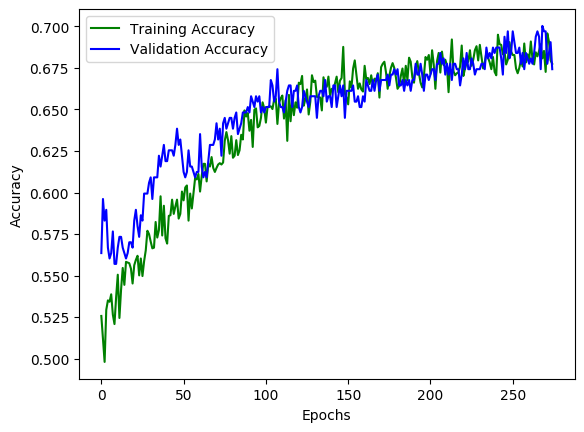

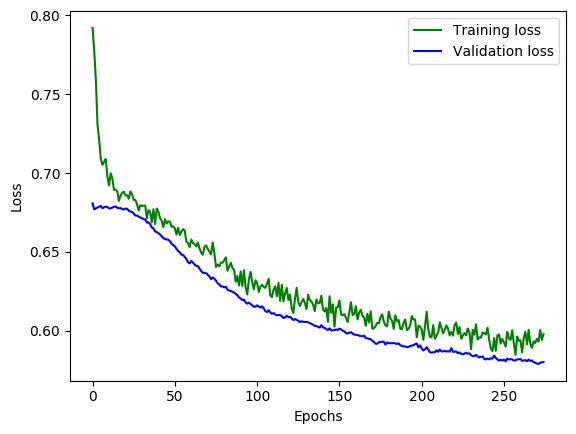

The training accuracy is: 0.704804539680481
The training loss is: 0.5696613142078785
The test accuracy is: 0.7003257328990228
Train RMSE: 0.75 RMSE
Test RMSE: 0.76 RMSE



In [44]:
### Final Model used for Prediction        

# epochs
f_epochs = 275

# Building a multilayer neural network using Keras
fmodel = Sequential()

fmodel.add(Dense(dims, input_dim = dims, activation = 'selu'))
fmodel.add(Dropout(0.5))
fmodel.add(Dense(dims, activation = 'tanh'))
fmodel.add(Dropout(0.5))
fmodel.add(Dense(dims, activation = 'selu'))
fmodel.add(Dropout(0.5))
        
fmodel.add(Dense(1, activation = 'sigmoid'))
        
# Compile the model to provide the training parameters
fmodel.compile(optimizer = tf.optimizers.SGD(lr = 0.01), loss = 'binary_crossentropy', metrics = ['accuracy'])        

# Train the model
nn_historyf = fmodel.fit(X_train, y_train, epochs = f_epochs, verbose = 1, validation_data = (X_val, y_val))
 
# Evaluate the trained model
nn_evalf = fmodel.evaluate(X_train, y_train)
        
# Predicting classes using the testing data
y_test_pred = fmodel.predict_classes(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Plot Accuracy
loss_train = nn_historyf.history['accuracy']
loss_val = nn_historyf.history['val_accuracy']
epochs = range(0, f_epochs)
plt.plot(epochs, loss_train, 'g', label = 'Training Accuracy')
plt.plot(epochs, loss_val, 'b', label = 'Validation Accuracy')
#plt.title("Optimizer: %s - Learning Rate: %f" % (opt, lr))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
        
# Plot Loss
loss_train = nn_historyf.history['loss']
loss_val = nn_historyf.history['val_loss']
epochs = range(0, f_epochs)
plt.plot(epochs, loss_train, 'g', label = 'Training loss')
plt.plot(epochs, loss_val, 'b', label = 'Validation loss')
#plt.title("Optimizer: %s - Learning Rate: %f" % (opt, lr))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
        
# Printing metrics
print(f"The training accuracy is: {nn_evalf[1]}")
print(f"The training loss is: {nn_evalf[0]}")
print(f"The test accuracy is: {test_accuracy}")
get_rmse(fmodel)
print()

[[102  56]
 [ 36 113]]


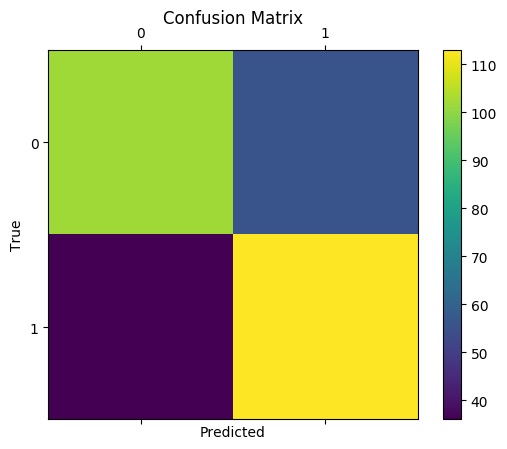

In [45]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

labels = [0, 1]
cm = confusion_matrix(y_test, y_test_pred, labels)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion Matrix')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [46]:
# Classification Report
from sklearn.metrics import classification_report
 
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.74      0.65      0.69       158
           1       0.67      0.76      0.71       149

    accuracy                           0.70       307
   macro avg       0.70      0.70      0.70       307
weighted avg       0.70      0.70      0.70       307



### `Neural Network - PCA`

In [47]:
# Dimensions for pca model
dims2 = pca_features.shape[1]
print(dims2)

72


In [48]:
"""
# List of optimizers and learning rates to be looped through
list_optimizers = ['Adam', 'SGD', 'Adadelta', 'RMSprop', 'Adagrad', 'Adamax', 'Nadam']
learning_rates = [0.00001, 0.0001, 0.001, 0.01, 0.1]

# Number of epochs per model
pca_epochs = 400

# Validation Split
val_split = 0.2

# Initializing a DataFrame to save each model results
pca_results = pd.DataFrame()

# Loop
for opt in list_optimizers:
    for lr in learning_rates:
        
        # Building a multilayer neural network using Keras
        pca = Sequential()

        pca.add(Dense(dims2, input_dim = dims2, activation = 'relu'))
        #pca.add(Dropout(0.25))
        pca.add(Dense(dims2 * .66, activation = 'relu'))
        #pca.add(Dropout(0.25))
        
        pca.add(Dense(1, activation = 'sigmoid'))
        
        # Compile the model to provide the training parameters
        pca.compile(optimizer = select_optimizer(opt, lr), loss = 'binary_crossentropy', metrics = ['accuracy'])
        
        # Train the model
        pca_history = pca.fit(X_train2, y_train2, epochs = pca_epochs, verbose = 1, validation_split = val_split)
        #pca_history = pca.fit(X_train2, y_train2, epochs = pca_epochs, verbose = 1, validation_data = (X_val, y_val))
 
        # Evaluate the trained model
        pca_eval = pca.evaluate(X_train2, y_train2)
        
        # Predicting using the testing data
        y_test_pred_pca = pca.predict_classes(X_test2)
        test_accuracy_pca = accuracy_score(y_test2, y_test_pred_pca)
        
        # New row for results dataframe containing model hyperparameters and results
        new_row = {'epochs': pca_epochs,
                   #'validation_split': val_split,
                   'training accuracy': pca_eval[1],
                   'training loss': pca_eval[0],
                   'testing accuracy': test_accuracy_pca,
                   'optimizer': str(opt),
                   'learning_rate': lr
                   }
        pca_results = pca_results.append(new_row, ignore_index = True)
        
        # Plot Accuracy
        loss_train = pca_history.history['accuracy']
        loss_val = pca_history.history['val_accuracy']
        epochs = range(0, pca_epochs)
        plt.plot(epochs, loss_train, 'g', label = 'Training Accuracy')
        plt.plot(epochs, loss_val, 'b', label = 'Validation Accuracy')
        plt.title("Optimizer: %s - Learning Rate: %f" % (opt, lr))
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()
        
        # Plot Loss
        loss_train = pca_history.history['loss']
        loss_val = pca_history.history['val_loss']
        epochs = range(0, pca_epochs)
        plt.plot(epochs, loss_train, 'g', label = 'Training loss')
        plt.plot(epochs, loss_val, 'b', label = 'Validation loss')
        plt.title("Optimizer: %s - Learning Rate: %f" % (opt, lr))
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        
        # Printing metrics
        print(f"The training accuracy is: {pca_eval[1]}")
        print(f"The training loss is: {pca_eval[0]}")
        print(f"The test accuracy is: {test_accuracy_pca}")
        print()
"""

'\n# List of optimizers and learning rates to be looped through\nlist_optimizers = [\'Adam\', \'SGD\', \'Adadelta\', \'RMSprop\', \'Adagrad\', \'Adamax\', \'Nadam\']\nlearning_rates = [0.00001, 0.0001, 0.001, 0.01, 0.1]\n\n# Number of epochs per model\npca_epochs = 400\n\n# Validation Split\nval_split = 0.2\n\n# Initializing a DataFrame to save each model results\npca_results = pd.DataFrame()\n\n# Loop\nfor opt in list_optimizers:\n    for lr in learning_rates:\n        \n        # Building a multilayer neural network using Keras\n        pca = Sequential()\n\n        pca.add(Dense(dims2, input_dim = dims2, activation = \'relu\'))\n        #pca.add(Dropout(0.25))\n        pca.add(Dense(dims2 * .66, activation = \'relu\'))\n        #pca.add(Dropout(0.25))\n        \n        pca.add(Dense(1, activation = \'sigmoid\'))\n        \n        # Compile the model to provide the training parameters\n        pca.compile(optimizer = select_optimizer(opt, lr), loss = \'binary_crossentropy\', metric

In [49]:
"""
# Display results of each model
pca_results = pca_results.sort_values(by = 'testing accuracy', ascending = True)
pca_results.head(50)
"""

"\n# Display results of each model\npca_results = pca_results.sort_values(by = 'testing accuracy', ascending = True)\npca_results.head(50)\n"

### `Neural Network - PCA Final Model`

Train on 1964 samples, validate on 492 samples
Epoch 1/400
1964/1964 [==============================] - 1s 295us/sample - loss: 0.7093 - accuracy: 0.5255 - val_loss: 0.6815 - val_accuracy: 0.5488
Epoch 2/400
1964/1964 [==============================] - 0s 52us/sample - loss: 0.6819 - accuracy: 0.5652 - val_loss: 0.6754 - val_accuracy: 0.5833
Epoch 3/400
1964/1964 [==============================] - 0s 49us/sample - loss: 0.6771 - accuracy: 0.5601 - val_loss: 0.6705 - val_accuracy: 0.5813
Epoch 4/400
1964/1964 [==============================] - 0s 45us/sample - loss: 0.6780 - accuracy: 0.5708 - val_loss: 0.6665 - val_accuracy: 0.5976
Epoch 5/400
1964/1964 [==============================] - 0s 51us/sample - loss: 0.6724 - accuracy: 0.5743 - val_loss: 0.6615 - val_accuracy: 0.6077
Epoch 6/400
1964/1964 [==============================] - 0s 90us/sample - loss: 0.6701 - accuracy: 0.5825 - val_loss: 0.6592 - val_accuracy: 0.6057
Epoch 7/400
1964/1964 [==============================] - 0s 66us

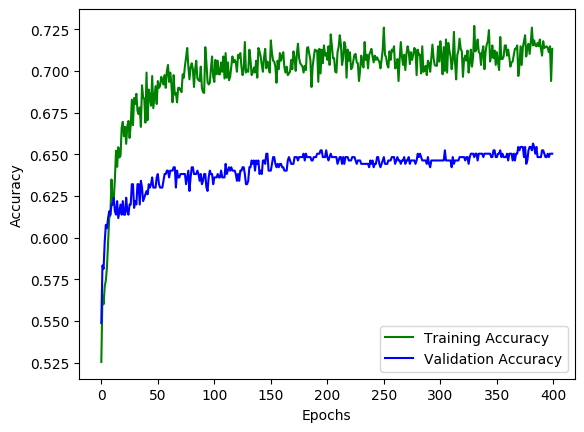

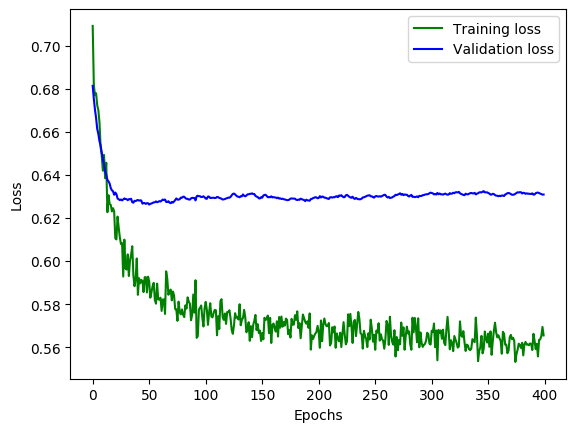

The training accuracy is: 0.7031759023666382
The training loss is: 0.5629871336178982
The test accuracy is: 0.6710097719869706



In [50]:
### Final Model used for Prediction        
# Building a multilayer neural network using Keras

pca_epochs2 = 400
val_split = 0.2

pca2 = Sequential()

pca2.add(Dense(dims2, input_dim = dims2, activation = 'tanh'))
pca2.add(Dropout(0.5))
pca2.add(Dense(dims2, activation = 'tanh'))
pca2.add(Dropout(0.5))
pca2.add(Dense(dims2, activation = 'tanh'))
pca2.add(Dropout(0.25))
        
pca2.add(Dense(1, activation = 'sigmoid'))

# Compile the model to provide the training parameters
pca2.compile(optimizer = tf.optimizers.Adagrad(lr = 0.01), loss = 'binary_crossentropy', metrics = ['accuracy'])
        
# Train the model
pca_history2 = pca2.fit(X_train2, y_train2, epochs = pca_epochs2, verbose = 1, validation_split = val_split)
 
# Evaluate the trained model
pca_eval2 = pca2.evaluate(X_train2, y_train2)
        
# Predicting using the testing data
y_test_pred_pca2 = pca2.predict_classes(X_test2)
test_accuracy_pca2 = accuracy_score(y_test2, y_test_pred_pca2)

# Plot Accuracy
loss_train = pca_history2.history['accuracy']
loss_val = pca_history2.history['val_accuracy']
epochs = range(0, pca_epochs2)
plt.plot(epochs, loss_train, 'g', label = 'Training Accuracy')
plt.plot(epochs, loss_val, 'b', label = 'Validation Accuracy')
#plt.title("Optimizer: %s - Learning Rate: %f" % (opt, lr))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
        
# Plot Loss
loss_train = pca_history2.history['loss']
loss_val = pca_history2.history['val_loss']
epochs = range(0, pca_epochs2)
plt.plot(epochs, loss_train, 'g', label = 'Training loss')
plt.plot(epochs, loss_val, 'b', label = 'Validation loss')
#plt.title("Optimizer: %s - Learning Rate: %f" % (opt, lr))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
        
# Printing metrics
print(f"The training accuracy is: {pca_eval2[1]}")
print(f"The training loss is: {pca_eval2[0]}")
print(f"The test accuracy is: {test_accuracy_pca2}")
print()

[[179  96]
 [106 233]]


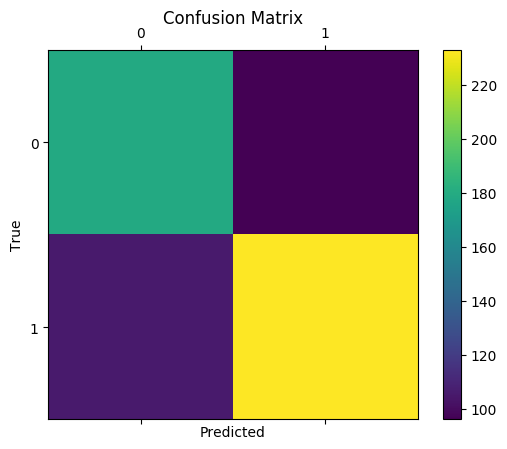

In [51]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

labels = [0, 1]
cm2 = confusion_matrix(y_test2, y_test_pred_pca2, labels)
print(cm2)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm2)
plt.title('Confusion Matrix')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [52]:
# Classification Report
from sklearn.metrics import classification_report
 
print(classification_report(y_test2, y_test_pred_pca2))

              precision    recall  f1-score   support

           0       0.63      0.65      0.64       275
           1       0.71      0.69      0.70       339

    accuracy                           0.67       614
   macro avg       0.67      0.67      0.67       614
weighted avg       0.67      0.67      0.67       614



### `Predictions - DENSE DataFrame`

#### `Team Metrics DataFrame`

In [53]:
# Copy of initial dataframe. 
teamMetrics = df.copy()

# Slicing dataframe
# Changing to 2022-23 season ONLY now
teamMetrics = teamMetrics[teamMetrics['season'] >= 2022]

# Display datafeame
teamMetrics.head()

,team,season,name,gameId,playerTeam,opposingTeam,Shootout Game,OT Game,Win,Loss,SavePercentage,home_or_away,gameDate,position,situation,xGoalsPercentage,corsiPercentage,fenwickPercentage,iceTime,xOnGoalFor,xGoalsFor,xReboundsFor,xFreezeFor,xPlayStoppedFor,xPlayContinuedInZoneFor,xPlayContinuedOutsideZoneFor,flurryAdjustedxGoalsFor,scoreVenueAdjustedxGoalsFor,flurryScoreVenueAdjustedxGoalsFor,shotsOnGoalFor,missedShotsFor,blockedShotAttemptsFor,shotAttemptsFor,goalsFor,reboundsFor,reboundGoalsFor,freezeFor,playStoppedFor,playContinuedInZoneFor,playContinuedOutsideZoneFor,savedShotsOnGoalFor,savedUnblockedShotAttemptsFor,penaltiesFor,penalityMinutesFor,faceOffsWonFor,hitsFor,takeawaysFor,giveawaysFor,lowDangerShotsFor,mediumDangerShotsFor,highDangerShotsFor,lowDangerxGoalsFor,mediumDangerxGoalsFor,highDangerxGoalsFor,lowDangerGoalsFor,mediumDangerGoalsFor,highDangerGoalsFor,scoreAdjustedShotsAttemptsFor,unblockedShotAttemptsFor,scoreAdjustedUnblockedShotAttemptsFor,dZoneGiveawaysFor,xGoalsFromxReboundsOfShotsFor,xGoalsFromActualReboundsOfShotsFor,reboundxGoalsFor,totalShotCreditFor,scoreAdjustedTotalShotCreditFor,scoreFlurryAdjustedTotalShotCreditFor,xOnGoalAgainst,xGoalsAgainst,xReboundsAgainst,xFreezeAgainst,xPlayStoppedAgainst,xPlayContinuedInZoneAgainst,xPlayContinuedOutsideZoneAgainst,flurryAdjustedxGoalsAgainst,scoreVenueAdjustedxGoalsAgainst,flurryScoreVenueAdjustedxGoalsAgainst,shotsOnGoalAgainst,missedShotsAgainst,blockedShotAttemptsAgainst,shotAttemptsAgainst,goalsAgainst,reboundsAgainst,reboundGoalsAgainst,freezeAgainst,playStoppedAgainst,playContinuedInZoneAgainst,playContinuedOutsideZoneAgainst,savedShotsOnGoalAgainst,savedUnblockedShotAttemptsAgainst,penaltiesAgainst,penalityMinutesAgainst,faceOffsWonAgainst,hitsAgainst,takeawaysAgainst,giveawaysAgainst,lowDangerShotsAgainst,mediumDangerShotsAgainst,highDangerShotsAgainst,lowDangerxGoalsAgainst,mediumDangerxGoalsAgainst,highDangerxGoalsAgainst,lowDangerGoalsAgainst,mediumDangerGoalsAgainst,highDangerGoalsAgainst,scoreAdjustedShotsAttemptsAgainst,unblockedShotAttemptsAgainst,scoreAdjustedUnblockedShotAttemptsAgainst,dZoneGiveawaysAgainst,xGoalsFromxReboundsOfShotsAgainst,xGoalsFromActualReboundsOfShotsAgainst,reboundxGoalsAgainst,totalShotCreditAgainst,scoreAdjustedTotalShotCreditAgainst,scoreFlurryAdjustedTotalShotCreditAgainst,playoffGame,year,month,day,home_or_away#,team#,opposingTeam#
6546,SJS,2022,SJS,2022020001,SJS,NSH,0,0,0,1,0.875000,AWAY,2022-10-07,Team Level,all,0.3112,0.4524,0.5000,3600.0,33.364,2.393,2.588,7.792,1.142,19.139,12.946,2.317,2.402,2.326,31.0,15.0,11.0,57.0,1.0,4.0,0.0,6.0,1.0,19.0,15.0,30.0,45.0,5.0,13.0,36.0,22.0,3.0,8.0,36.0,7.0,3.0,0.785,0.790,0.818,1.0,0.0,0.0,55.981,46.0,45.277,4.0,0.594,0.829,0.829,2.158,2.175,2.164,34.405,5.297,2.985,7.443,1.171,17.230,11.874,4.834,5.274,4.813,32.0,14.0,23.0,69.0,4.0,4.0,1.0,9.0,1.0,14.0,15.0,28.0,42.0,5.0,13.0,30.0,23.0,4.0,3.0,23.0,17.0,6.0,0.944,2.275,2.079,2.0,0.0,2.0,70.090,46.0,46.576,2.0,0.675,0.949,0.949,5.024,4.992,4.658,0,2022,10,7,0,24,17
139571,NSH,2022,NSH,2022020001,NSH,SJS,0,0,1,0,0.967742,HOME,2022-10-07,Team Level,all,0.6888,0.5476,0.5000,3600.0,34.405,5.297,2.985,7.443,1.171,17.230,11.874,4.834,5.274,4.813,32.0,14.0,23.0,69.0,4.0,4.0,1.0,9.0,1.0,14.0,15.0,28.0,42.0,5.0,13.0,30.0,23.0,4.0,3.0,23.0,17.0,6.0,0.944,2.275,2.079,2.0,0.0,2.0,70.090,46.0,46.576,2.0,0.675,0.949,0.949,5.024,4.992,4.658,33.364,2.393,2.588,7.792,1.142,19.139,12.946,2.317,2.402,2.326,31.0,15.0,11.0,57.0,1.0,4.0,0.0,6.0,1.0,19.0,15.0,30.0,45.0,5.0,13.0,36.0,22.0,3.0,8.0,36.0,7.0,3.0,0.785,0.790,0.818,1.0,0.0,0.0,55.981,46.0,45.277,4.0,0.594,0.829,0.829,2.158,2.175,2.164,0,2022,10,7,1,17,24
139576,NSH,2022,NSH,2022020002,NSH,SJS,0,0,1,0,0.939394,AWAY,2022-10-08,Team Level,all,0.2896,0.4224,0.4286,3600.0,23.792,1.403,1.546,6.408,0.838,13.142,9.662,1.371,1.453,1.419,18.0,15.0,16.0,49.0,3.0,4.0,2.0,6.0,3.0,9.0,8.0,15.0,30.0,4.0,8.0,34.0,33.0,11.0,8.0,29.0,3.0,1.0,0.828,0.303,0.271,1.0,1.0,1.0,50.331,33.0,33.446,5.0,0.

In [54]:
# Filtering DataFrame for metric columns only

filtered = teamMetrics[['team','home_or_away','xGoalsPercentage','corsiPercentage','fenwickPercentage','iceTime','xOnGoalFor',
 'xGoalsFor','xReboundsFor','xFreezeFor','xPlayStoppedFor','xPlayContinuedInZoneFor','xPlayContinuedOutsideZoneFor',
 'flurryAdjustedxGoalsFor','scoreVenueAdjustedxGoalsFor','flurryScoreVenueAdjustedxGoalsFor','shotsOnGoalFor',
 'missedShotsFor','blockedShotAttemptsFor','shotAttemptsFor','goalsFor','reboundsFor','reboundGoalsFor','freezeFor',
 'playStoppedFor','playContinuedInZoneFor','playContinuedOutsideZoneFor','savedShotsOnGoalFor','savedUnblockedShotAttemptsFor',
 'penaltiesFor','penalityMinutesFor','faceOffsWonFor','hitsFor','takeawaysFor','giveawaysFor','lowDangerShotsFor',
 'mediumDangerShotsFor','highDangerShotsFor','lowDangerxGoalsFor','mediumDangerxGoalsFor','highDangerxGoalsFor',
 'lowDangerGoalsFor', 'mediumDangerGoalsFor','highDangerGoalsFor','scoreAdjustedShotsAttemptsFor','unblockedShotAttemptsFor',
 'scoreAdjustedUnblockedShotAttemptsFor','dZoneGiveawaysFor','xGoalsFromxReboundsOfShotsFor','xGoalsFromActualReboundsOfShotsFor',
 'reboundxGoalsFor','totalShotCreditFor','scoreAdjustedTotalShotCreditFor','scoreFlurryAdjustedTotalShotCreditFor',
 'xOnGoalAgainst','xGoalsAgainst','xReboundsAgainst','xFreezeAgainst','xPlayStoppedAgainst','xPlayContinuedInZoneAgainst',
 'xPlayContinuedOutsideZoneAgainst','flurryAdjustedxGoalsAgainst','scoreVenueAdjustedxGoalsAgainst',
 'flurryScoreVenueAdjustedxGoalsAgainst','shotsOnGoalAgainst','missedShotsAgainst','blockedShotAttemptsAgainst',
 'shotAttemptsAgainst','goalsAgainst','reboundsAgainst','reboundGoalsAgainst','freezeAgainst','playStoppedAgainst',
 'playContinuedInZoneAgainst','playContinuedOutsideZoneAgainst','savedShotsOnGoalAgainst','savedUnblockedShotAttemptsAgainst',
 'penaltiesAgainst','penalityMinutesAgainst','faceOffsWonAgainst','hitsAgainst','takeawaysAgainst','giveawaysAgainst',
 'lowDangerShotsAgainst','mediumDangerShotsAgainst','highDangerShotsAgainst','lowDangerxGoalsAgainst','mediumDangerxGoalsAgainst',
 'highDangerxGoalsAgainst','lowDangerGoalsAgainst','mediumDangerGoalsAgainst','highDangerGoalsAgainst',
 'scoreAdjustedShotsAttemptsAgainst','unblockedShotAttemptsAgainst','scoreAdjustedUnblockedShotAttemptsAgainst',
 'dZoneGiveawaysAgainst','xGoalsFromxReboundsOfShotsAgainst','xGoalsFromActualReboundsOfShotsAgainst','reboundxGoalsAgainst',
 'totalShotCreditAgainst','scoreAdjustedTotalShotCreditAgainst','scoreFlurryAdjustedTotalShotCreditAgainst']]

In [55]:
# List of column names to normalize
cols_to_normalize =  ['xGoalsPercentage','corsiPercentage','fenwickPercentage','iceTime','xOnGoalFor','xGoalsFor','xReboundsFor',
 'xFreezeFor', 'xPlayStoppedFor', 'xPlayContinuedInZoneFor', 'xPlayContinuedOutsideZoneFor', 'flurryAdjustedxGoalsFor',
 'scoreVenueAdjustedxGoalsFor', 'flurryScoreVenueAdjustedxGoalsFor', 'shotsOnGoalFor', 'missedShotsFor', 'blockedShotAttemptsFor',
 'shotAttemptsFor', 'goalsFor', 'reboundsFor', 'reboundGoalsFor', 'freezeFor', 'playStoppedFor', 'playContinuedInZoneFor',
 'playContinuedOutsideZoneFor', 'savedShotsOnGoalFor', 'savedUnblockedShotAttemptsFor', 'penaltiesFor', 'penalityMinutesFor',
 'faceOffsWonFor', 'hitsFor', 'takeawaysFor', 'giveawaysFor', 'lowDangerShotsFor', 'mediumDangerShotsFor', 'highDangerShotsFor',
 'lowDangerxGoalsFor', 'mediumDangerxGoalsFor', 'highDangerxGoalsFor', 'lowDangerGoalsFor', 'mediumDangerGoalsFor',
 'highDangerGoalsFor', 'scoreAdjustedShotsAttemptsFor', 'unblockedShotAttemptsFor', 'scoreAdjustedUnblockedShotAttemptsFor',
 'dZoneGiveawaysFor', 'xGoalsFromxReboundsOfShotsFor', 'xGoalsFromActualReboundsOfShotsFor', 'reboundxGoalsFor',
 'totalShotCreditFor', 'scoreAdjustedTotalShotCreditFor', 'scoreFlurryAdjustedTotalShotCreditFor', 'xOnGoalAgainst',
 'xGoalsAgainst', 'xReboundsAgainst', 'xFreezeAgainst', 'xPlayStoppedAgainst', 'xPlayContinuedInZoneAgainst',
 'xPlayContinuedOutsideZoneAgainst', 'flurryAdjustedxGoalsAgainst', 'scoreVenueAdjustedxGoalsAgainst',
 'flurryScoreVenueAdjustedxGoalsAgainst', 'shotsOnGoalAgainst', 'missedShotsAgainst', 'blockedShotAttemptsAgainst',
 'shotAttemptsAgainst', 'goalsAgainst', 'reboundsAgainst', 'reboundGoalsAgainst', 'freezeAgainst', 'playStoppedAgainst',
 'playContinuedInZoneAgainst', 'playContinuedOutsideZoneAgainst', 'savedShotsOnGoalAgainst', 'savedUnblockedShotAttemptsAgainst',
 'penaltiesAgainst', 'penalityMinutesAgainst', 'faceOffsWonAgainst', 'hitsAgainst', 'takeawaysAgainst', 'giveawaysAgainst',
 'lowDangerShotsAgainst', 'mediumDangerShotsAgainst', 'highDangerShotsAgainst', 'lowDangerxGoalsAgainst',
 'mediumDangerxGoalsAgainst', 'highDangerxGoalsAgainst', 'lowDangerGoalsAgainst', 'mediumDangerGoalsAgainst',
 'highDangerGoalsAgainst', 'scoreAdjustedShotsAttemptsAgainst', 'unblockedShotAttemptsAgainst',
 'scoreAdjustedUnblockedShotAttemptsAgainst', 'dZoneGiveawaysAgainst', 'xGoalsFromxReboundsOfShotsAgainst',
 'xGoalsFromActualReboundsOfShotsAgainst','reboundxGoalsAgainst', 'totalShotCreditAgainst',
 'scoreAdjustedTotalShotCreditAgainst','scoreFlurryAdjustedTotalShotCreditAgainst']

In [56]:
# Normalizing the data
min_max_scaler = preprocessing.MinMaxScaler()
filtered[cols_to_normalize] = min_max_scaler.fit_transform(filtered[cols_to_normalize])

# Grouping the data and finding the mean
grouped = filtered.groupby(['team', 'home_or_away']).mean()

# Unpivot 1st level
grouped.reset_index(level=1, inplace=True)

# Unpivot 2nd level
grouped.reset_index(level=0, inplace=True)

# Creating pickle of teams_metrics DataFrame - save file
grouped.to_pickle('/Users/nathananderson/Desktop/team_metrics.pkl')
print('** DataFrame saved to Pickle file.')

** DataFrame saved to Pickle file.


In [57]:
grouped.head()

,team,home_or_away,xGoalsPercentage,corsiPercentage,fenwickPercentage,iceTime,xOnGoalFor,xGoalsFor,xReboundsFor,xFreezeFor,xPlayStoppedFor,xPlayContinuedInZoneFor,xPlayContinuedOutsideZoneFor,flurryAdjustedxGoalsFor,scoreVenueAdjustedxGoalsFor,flurryScoreVenueAdjustedxGoalsFor,shotsOnGoalFor,missedShotsFor,blockedShotAttemptsFor,shotAttemptsFor,goalsFor,reboundsFor,reboundGoalsFor,freezeFor,playStoppedFor,playContinuedInZoneFor,playContinuedOutsideZoneFor,savedShotsOnGoalFor,savedUnblockedShotAttemptsFor,penaltiesFor,penalityMinutesFor,faceOffsWonFor,hitsFor,takeawaysFor,giveawaysFor,lowDangerShotsFor,mediumDangerShotsFor,highDangerShotsFor,lowDangerxGoalsFor,mediumDangerxGoalsFor,highDangerxGoalsFor,lowDangerGoalsFor,mediumDangerGoalsFor,highDangerGoalsFor,scoreAdjustedShotsAttemptsFor,unblockedShotAttemptsFor,scoreAdjustedUnblockedShotAttemptsFor,dZoneGiveawaysFor,xGoalsFromxReboundsOfShotsFor,xGoalsFromActualReboundsOfShotsFor,reboundxGoalsFor,totalShotCreditFor,scoreAdjustedTotalShotCreditFor,scoreFlurryAdjustedTotalShotCreditFor,xOnGoalAgainst,xGoalsAgainst,xReboundsAgainst,xFreezeAgainst,xPlayStoppedAgainst,xPlayContinuedInZoneAgainst,xPlayContinuedOutsideZoneAgainst,flurryAdjustedxGoalsAgainst,scoreVenueAdjustedxGoalsAgainst,flurryScoreVenueAdjustedxGoalsAgainst,shotsOnGoalAgainst,missedShotsAgainst,blockedShotAttemptsAgainst,shotAttemptsAgainst,goalsAgainst,reboundsAgainst,reboundGoalsAgainst,freezeAgainst,playStoppedAgainst,playContinuedInZoneAgainst,playContinuedOutsideZoneAgainst,savedShotsOnGoalAgainst,savedUnblockedShotAttemptsAgainst,penaltiesAgainst,penalityMinutesAgainst,faceOffsWonAgainst,hitsAgainst,takeawaysAgainst,giveawaysAgainst,lowDangerShotsAgainst,mediumDangerShotsAgainst,highDangerShotsAgainst,lowDangerxGoalsAgainst,mediumDangerxGoalsAgainst,highDangerxGoalsAgainst,lowDangerGoalsAgainst,mediumDangerGoalsAgainst,highDangerGoalsAgainst,scoreAdjustedShotsAttemptsAgainst,unblockedShotAttemptsAgainst,scoreAdjustedUnblockedShotAttemptsAgainst,dZoneGiveawaysAgainst,xGoalsFromxReboundsOfShotsAgainst,xGoalsFromActualReboundsOfShotsAgainst,reboundxGoalsAgainst,totalShotCreditAgainst,scoreAdjustedTotalShotCreditAgainst,scoreFlurryAdjustedTotalShotCreditAgainst
0,ANA,AWAY,0.342980,0.379444,0.341453,0.0,0.242197,0.231327,0.249141,0.276991,0.270903,0.261575,0.294921,0.251405,0.226540,0.254104,0.245192,0.243534,0.397917,0.271875,0.208333,0.200893,0.078125,0.330882,0.137500,0.332721,0.288462,0.266827,0.268849,0.375000,0.322581,0.373476,0.253409,0.237981,0.278017,0.361250,0.267500,0.137500,0.241667,0.259894,0.157646,0.125000,0.031250,0.187500,0.252809,0.238911,0.263020,0.258929,0.251109,0.160184,0.160184,0.196484,0.194376,0.222647,0.453830,0.454178,0.496290,0.424694,0.491054,0.501395,0.482340,0.497105,0.430519,0.485848,0.433894,0.383621,0.383333,0.439844,0.520833,0.258929,0.140625,0.433824,0.300000,0.452206,0.427885,0.401442,0.444444,0.322917,0.286290,0.515244,0.277273,0.283654,0.329741,0.466250,0.557500,0.229167,0.491777,0.531045,0.203541,0.250000,0.364583,0.200000,0.441084,0.462702,0.490689,0.267857,0.474097,0.257510,0.258344,0.389349,0.370676,0.425467
1,ANA,HOME,0.390081,0.415541,0.401428,0.0,0.305480,0.270234,0.317388,0.296111,0.327536,0.345523,0.377638,0.295718,0.241962,0.272671,0.257692,0.372414,0.377778,0.319167,0.200000,0.147619,0.083333,0.380392,0.106667,0.374510,0.407692,0.280769,0.339683,0.366667,0.309677,0.377236,0.238788,0.200000,0.312644,0.382667,0.400000,0.137778,0.360747,0.355625,0.110188,0.122222,0.133333,0.053333,0.276486,0.309677,0.306084,0.253968,0.306633,0.120619,0.121403,0.256273,0.231892,0.265142,0.447370,0.429989,0.462261,0.431488,0.504883,0.466889,0.512555,0.472819,0.444545,0.504119,0.423077,0.383908,0.442222,0.455000,0.496296,0.285714,0.116667,0.388235,0.186667,0.405882,0.512821,0.394872,0.439153,0.327778,0.279570,0.482927,0.249697,0.235897,0.264368,0.557333,0.304000,0.311111,0.446962,0.294983,0.334365,0.188889,0.222222,0.400000,0.504439,0.453763,0.534662,0.187302,0.460837,0.249502,0.249502,0

#### `CURRENT - Team Metrics DataFrame`

* Loading previously self-created dataset of Team Metrics separated by Home or Away

In [58]:
# Read teams pickle file as dataframe
team_metrics = grouped.copy()
#team_metrics = pd.read_pickle('/Users/nathananderson/Documents/Data_Science/NN/Project/team_metrics.pkl')
team_metrics.head()

,team,home_or_away,xGoalsPercentage,corsiPercentage,fenwickPercentage,iceTime,xOnGoalFor,xGoalsFor,xReboundsFor,xFreezeFor,xPlayStoppedFor,xPlayContinuedInZoneFor,xPlayContinuedOutsideZoneFor,flurryAdjustedxGoalsFor,scoreVenueAdjustedxGoalsFor,flurryScoreVenueAdjustedxGoalsFor,shotsOnGoalFor,missedShotsFor,blockedShotAttemptsFor,shotAttemptsFor,goalsFor,reboundsFor,reboundGoalsFor,freezeFor,playStoppedFor,playContinuedInZoneFor,playContinuedOutsideZoneFor,savedShotsOnGoalFor,savedUnblockedShotAttemptsFor,penaltiesFor,penalityMinutesFor,faceOffsWonFor,hitsFor,takeawaysFor,giveawaysFor,lowDangerShotsFor,mediumDangerShotsFor,highDangerShotsFor,lowDangerxGoalsFor,mediumDangerxGoalsFor,highDangerxGoalsFor,lowDangerGoalsFor,mediumDangerGoalsFor,highDangerGoalsFor,scoreAdjustedShotsAttemptsFor,unblockedShotAttemptsFor,scoreAdjustedUnblockedShotAttemptsFor,dZoneGiveawaysFor,xGoalsFromxReboundsOfShotsFor,xGoalsFromActualReboundsOfShotsFor,reboundxGoalsFor,totalShotCreditFor,scoreAdjustedTotalShotCreditFor,scoreFlurryAdjustedTotalShotCreditFor,xOnGoalAgainst,xGoalsAgainst,xReboundsAgainst,xFreezeAgainst,xPlayStoppedAgainst,xPlayContinuedInZoneAgainst,xPlayContinuedOutsideZoneAgainst,flurryAdjustedxGoalsAgainst,scoreVenueAdjustedxGoalsAgainst,flurryScoreVenueAdjustedxGoalsAgainst,shotsOnGoalAgainst,missedShotsAgainst,blockedShotAttemptsAgainst,shotAttemptsAgainst,goalsAgainst,reboundsAgainst,reboundGoalsAgainst,freezeAgainst,playStoppedAgainst,playContinuedInZoneAgainst,playContinuedOutsideZoneAgainst,savedShotsOnGoalAgainst,savedUnblockedShotAttemptsAgainst,penaltiesAgainst,penalityMinutesAgainst,faceOffsWonAgainst,hitsAgainst,takeawaysAgainst,giveawaysAgainst,lowDangerShotsAgainst,mediumDangerShotsAgainst,highDangerShotsAgainst,lowDangerxGoalsAgainst,mediumDangerxGoalsAgainst,highDangerxGoalsAgainst,lowDangerGoalsAgainst,mediumDangerGoalsAgainst,highDangerGoalsAgainst,scoreAdjustedShotsAttemptsAgainst,unblockedShotAttemptsAgainst,scoreAdjustedUnblockedShotAttemptsAgainst,dZoneGiveawaysAgainst,xGoalsFromxReboundsOfShotsAgainst,xGoalsFromActualReboundsOfShotsAgainst,reboundxGoalsAgainst,totalShotCreditAgainst,scoreAdjustedTotalShotCreditAgainst,scoreFlurryAdjustedTotalShotCreditAgainst
0,ANA,AWAY,0.342980,0.379444,0.341453,0.0,0.242197,0.231327,0.249141,0.276991,0.270903,0.261575,0.294921,0.251405,0.226540,0.254104,0.245192,0.243534,0.397917,0.271875,0.208333,0.200893,0.078125,0.330882,0.137500,0.332721,0.288462,0.266827,0.268849,0.375000,0.322581,0.373476,0.253409,0.237981,0.278017,0.361250,0.267500,0.137500,0.241667,0.259894,0.157646,0.125000,0.031250,0.187500,0.252809,0.238911,0.263020,0.258929,0.251109,0.160184,0.160184,0.196484,0.194376,0.222647,0.453830,0.454178,0.496290,0.424694,0.491054,0.501395,0.482340,0.497105,0.430519,0.485848,0.433894,0.383621,0.383333,0.439844,0.520833,0.258929,0.140625,0.433824,0.300000,0.452206,0.427885,0.401442,0.444444,0.322917,0.286290,0.515244,0.277273,0.283654,0.329741,0.466250,0.557500,0.229167,0.491777,0.531045,0.203541,0.250000,0.364583,0.200000,0.441084,0.462702,0.490689,0.267857,0.474097,0.257510,0.258344,0.389349,0.370676,0.425467
1,ANA,HOME,0.390081,0.415541,0.401428,0.0,0.305480,0.270234,0.317388,0.296111,0.327536,0.345523,0.377638,0.295718,0.241962,0.272671,0.257692,0.372414,0.377778,0.319167,0.200000,0.147619,0.083333,0.380392,0.106667,0.374510,0.407692,0.280769,0.339683,0.366667,0.309677,0.377236,0.238788,0.200000,0.312644,0.382667,0.400000,0.137778,0.360747,0.355625,0.110188,0.122222,0.133333,0.053333,0.276486,0.309677,0.306084,0.253968,0.306633,0.120619,0.121403,0.256273,0.231892,0.265142,0.447370,0.429989,0.462261,0.431488,0.504883,0.466889,0.512555,0.472819,0.444545,0.504119,0.423077,0.383908,0.442222,0.455000,0.496296,0.285714,0.116667,0.388235,0.186667,0.405882,0.512821,0.394872,0.439153,0.327778,0.279570,0.482927,0.249697,0.235897,0.264368,0.557333,0.304000,0.311111,0.446962,0.294983,0.334365,0.188889,0.222222,0.400000,0.504439,0.453763,0.534662,0.187302,0.460837,0.249502,0.249502,0

* Separating Team Metrics into Home and Away datasets to make it easier for lookup purposes while making predictions

In [59]:
# Home team metrics dataframe
home_metrics_mask = team_metrics.home_or_away == 'HOME'
home_metrics = pd.DataFrame()
home_metrics = home_metrics.append(team_metrics.loc[home_metrics_mask])
home_metrics.head()

,team,home_or_away,xGoalsPercentage,corsiPercentage,fenwickPercentage,iceTime,xOnGoalFor,xGoalsFor,xReboundsFor,xFreezeFor,xPlayStoppedFor,xPlayContinuedInZoneFor,xPlayContinuedOutsideZoneFor,flurryAdjustedxGoalsFor,scoreVenueAdjustedxGoalsFor,flurryScoreVenueAdjustedxGoalsFor,shotsOnGoalFor,missedShotsFor,blockedShotAttemptsFor,shotAttemptsFor,goalsFor,reboundsFor,reboundGoalsFor,freezeFor,playStoppedFor,playContinuedInZoneFor,playContinuedOutsideZoneFor,savedShotsOnGoalFor,savedUnblockedShotAttemptsFor,penaltiesFor,penalityMinutesFor,faceOffsWonFor,hitsFor,takeawaysFor,giveawaysFor,lowDangerShotsFor,mediumDangerShotsFor,highDangerShotsFor,lowDangerxGoalsFor,mediumDangerxGoalsFor,highDangerxGoalsFor,lowDangerGoalsFor,mediumDangerGoalsFor,highDangerGoalsFor,scoreAdjustedShotsAttemptsFor,unblockedShotAttemptsFor,scoreAdjustedUnblockedShotAttemptsFor,dZoneGiveawaysFor,xGoalsFromxReboundsOfShotsFor,xGoalsFromActualReboundsOfShotsFor,reboundxGoalsFor,totalShotCreditFor,scoreAdjustedTotalShotCreditFor,scoreFlurryAdjustedTotalShotCreditFor,xOnGoalAgainst,xGoalsAgainst,xReboundsAgainst,xFreezeAgainst,xPlayStoppedAgainst,xPlayContinuedInZoneAgainst,xPlayContinuedOutsideZoneAgainst,flurryAdjustedxGoalsAgainst,scoreVenueAdjustedxGoalsAgainst,flurryScoreVenueAdjustedxGoalsAgainst,shotsOnGoalAgainst,missedShotsAgainst,blockedShotAttemptsAgainst,shotAttemptsAgainst,goalsAgainst,reboundsAgainst,reboundGoalsAgainst,freezeAgainst,playStoppedAgainst,playContinuedInZoneAgainst,playContinuedOutsideZoneAgainst,savedShotsOnGoalAgainst,savedUnblockedShotAttemptsAgainst,penaltiesAgainst,penalityMinutesAgainst,faceOffsWonAgainst,hitsAgainst,takeawaysAgainst,giveawaysAgainst,lowDangerShotsAgainst,mediumDangerShotsAgainst,highDangerShotsAgainst,lowDangerxGoalsAgainst,mediumDangerxGoalsAgainst,highDangerxGoalsAgainst,lowDangerGoalsAgainst,mediumDangerGoalsAgainst,highDangerGoalsAgainst,scoreAdjustedShotsAttemptsAgainst,unblockedShotAttemptsAgainst,scoreAdjustedUnblockedShotAttemptsAgainst,dZoneGiveawaysAgainst,xGoalsFromxReboundsOfShotsAgainst,xGoalsFromActualReboundsOfShotsAgainst,reboundxGoalsAgainst,totalShotCreditAgainst,scoreAdjustedTotalShotCreditAgainst,scoreFlurryAdjustedTotalShotCreditAgainst
1,ANA,HOME,0.390081,0.415541,0.401428,0.0,0.305480,0.270234,0.317388,0.296111,0.327536,0.345523,0.377638,0.295718,0.241962,0.272671,0.257692,0.372414,0.377778,0.319167,0.200000,0.147619,0.083333,0.380392,0.106667,0.374510,0.407692,0.280769,0.339683,0.366667,0.309677,0.377236,0.238788,0.200000,0.312644,0.382667,0.400000,0.137778,0.360747,0.355625,0.110188,0.122222,0.133333,0.053333,0.276486,0.309677,0.306084,0.253968,0.306633,0.120619,0.121403,0.256273,0.231892,0.265142,0.447370,0.429989,0.462261,0.431488,0.504883,0.466889,0.512555,0.472819,0.444545,0.504119,0.423077,0.383908,0.442222,0.455000,0.496296,0.285714,0.116667,0.388235,0.186667,0.405882,0.512821,0.394872,0.439153,0.327778,0.279570,0.482927,0.249697,0.235897,0.264368,0.557333,0.304000,0.311111,0.446962,0.294983,0.334365,0.188889,0.222222,0.400000,0.504439,0.453763,0.534662,0.187302,0.460837,0.249502,0.249502,0.368837,0.383513,0.450485
3,ARI,HOME,0.358853,0.353950,0.344546,0.0,0.232038,0.310188,0.274455,0.234635,0.253877,0.275105,0.259125,0.345442,0.284968,0.326997,0.209790,0.300940,0.360606,0.255682,0.363636,0.116883,0.045455,0.272727,0.127273,0.363636,0.272727,0.204545,0.243867,0.333333,0.290323,0.399113,0.499174,0.181818,0.442006,0.290909,0.360000,0.206061,0.316707,0.340605,0.187945,0.196970,0.196970,0.181818,0.223340,0.236070,0.241588,0.346320,0.266621,0.115702,0.115702,0.292279,0.269655,0.311719,0.447437,0.553885,0.486204,0.418534,0.456674,0.459527,0.447915,0.581643,0.552458,0.599112,0.430070,0.351097,0.454545,0.452273,0.424242,0.292208,0.181818,0.433155,0.200000,0.451872,0.419580,0.414336,0.440115,0.310606,0.258065,0.454545,0.352066,0.181818,0.294671,0.520000,0.316364,0.375758,0.436042,0.324428,0.485982,0.181818,0.121212,0.400000,0.471614,0.444282,0.497937,0.142857,0.526097,0.326417,0.326417,0

In [60]:
# Away team metrics dataframe
away_metrics_mask = team_metrics.home_or_away == 'AWAY'
away_metrics = pd.DataFrame()
away_metrics = away_metrics.append(team_metrics.loc[away_metrics_mask])
away_metrics.head()

,team,home_or_away,xGoalsPercentage,corsiPercentage,fenwickPercentage,iceTime,xOnGoalFor,xGoalsFor,xReboundsFor,xFreezeFor,xPlayStoppedFor,xPlayContinuedInZoneFor,xPlayContinuedOutsideZoneFor,flurryAdjustedxGoalsFor,scoreVenueAdjustedxGoalsFor,flurryScoreVenueAdjustedxGoalsFor,shotsOnGoalFor,missedShotsFor,blockedShotAttemptsFor,shotAttemptsFor,goalsFor,reboundsFor,reboundGoalsFor,freezeFor,playStoppedFor,playContinuedInZoneFor,playContinuedOutsideZoneFor,savedShotsOnGoalFor,savedUnblockedShotAttemptsFor,penaltiesFor,penalityMinutesFor,faceOffsWonFor,hitsFor,takeawaysFor,giveawaysFor,lowDangerShotsFor,mediumDangerShotsFor,highDangerShotsFor,lowDangerxGoalsFor,mediumDangerxGoalsFor,highDangerxGoalsFor,lowDangerGoalsFor,mediumDangerGoalsFor,highDangerGoalsFor,scoreAdjustedShotsAttemptsFor,unblockedShotAttemptsFor,scoreAdjustedUnblockedShotAttemptsFor,dZoneGiveawaysFor,xGoalsFromxReboundsOfShotsFor,xGoalsFromActualReboundsOfShotsFor,reboundxGoalsFor,totalShotCreditFor,scoreAdjustedTotalShotCreditFor,scoreFlurryAdjustedTotalShotCreditFor,xOnGoalAgainst,xGoalsAgainst,xReboundsAgainst,xFreezeAgainst,xPlayStoppedAgainst,xPlayContinuedInZoneAgainst,xPlayContinuedOutsideZoneAgainst,flurryAdjustedxGoalsAgainst,scoreVenueAdjustedxGoalsAgainst,flurryScoreVenueAdjustedxGoalsAgainst,shotsOnGoalAgainst,missedShotsAgainst,blockedShotAttemptsAgainst,shotAttemptsAgainst,goalsAgainst,reboundsAgainst,reboundGoalsAgainst,freezeAgainst,playStoppedAgainst,playContinuedInZoneAgainst,playContinuedOutsideZoneAgainst,savedShotsOnGoalAgainst,savedUnblockedShotAttemptsAgainst,penaltiesAgainst,penalityMinutesAgainst,faceOffsWonAgainst,hitsAgainst,takeawaysAgainst,giveawaysAgainst,lowDangerShotsAgainst,mediumDangerShotsAgainst,highDangerShotsAgainst,lowDangerxGoalsAgainst,mediumDangerxGoalsAgainst,highDangerxGoalsAgainst,lowDangerGoalsAgainst,mediumDangerGoalsAgainst,highDangerGoalsAgainst,scoreAdjustedShotsAttemptsAgainst,unblockedShotAttemptsAgainst,scoreAdjustedUnblockedShotAttemptsAgainst,dZoneGiveawaysAgainst,xGoalsFromxReboundsOfShotsAgainst,xGoalsFromActualReboundsOfShotsAgainst,reboundxGoalsAgainst,totalShotCreditAgainst,scoreAdjustedTotalShotCreditAgainst,scoreFlurryAdjustedTotalShotCreditAgainst
0,ANA,AWAY,0.342980,0.379444,0.341453,0.0,0.242197,0.231327,0.249141,0.276991,0.270903,0.261575,0.294921,0.251405,0.226540,0.254104,0.245192,0.243534,0.397917,0.271875,0.208333,0.200893,0.078125,0.330882,0.137500,0.332721,0.288462,0.266827,0.268849,0.375000,0.322581,0.373476,0.253409,0.237981,0.278017,0.361250,0.267500,0.137500,0.241667,0.259894,0.157646,0.125000,0.031250,0.187500,0.252809,0.238911,0.263020,0.258929,0.251109,0.160184,0.160184,0.196484,0.194376,0.222647,0.453830,0.454178,0.496290,0.424694,0.491054,0.501395,0.482340,0.497105,0.430519,0.485848,0.433894,0.383621,0.383333,0.439844,0.520833,0.258929,0.140625,0.433824,0.300000,0.452206,0.427885,0.401442,0.444444,0.322917,0.286290,0.515244,0.277273,0.283654,0.329741,0.466250,0.557500,0.229167,0.491777,0.531045,0.203541,0.250000,0.364583,0.200000,0.441084,0.462702,0.490689,0.267857,0.474097,0.257510,0.258344,0.389349,0.370676,0.425467
2,ARI,AWAY,0.360744,0.342951,0.329737,0.0,0.183241,0.228170,0.204228,0.208320,0.202843,0.208655,0.221481,0.254606,0.225323,0.259329,0.181891,0.228448,0.325000,0.197917,0.273148,0.116071,0.062500,0.330882,0.150000,0.221814,0.310897,0.192308,0.200397,0.364583,0.315860,0.345528,0.328030,0.235577,0.278736,0.294167,0.248333,0.144444,0.213348,0.241443,0.174406,0.111111,0.104167,0.233333,0.188114,0.178763,0.205841,0.208333,0.214670,0.082565,0.082565,0.223301,0.222557,0.258413,0.383100,0.410943,0.422076,0.373579,0.419426,0.420730,0.409229,0.449924,0.387658,0.437444,0.347756,0.379310,0.419444,0.395833,0.425926,0.193452,0.156250,0.450980,0.233333,0.416667,0.366987,0.331731,0.384921,0.326389,0.297043,0.514228,0.322727,0.322115,0.326149,0.413333,0.478333,0.230556,0.430064,0.464306,0.207933,0.180556,0.305556,0.183333,0.386848,0.388441,0.410432,0.216270,0.413234,0.184003,0.184732,0

* Loading previously self-created dataset of Team Names and Abbreviations
  * Game level dataset only has team abbreviations and the schedule for 2022-23 only has the Team Name. This table will be used as a lookup table to join the other two tables together.

In [61]:
# Read teams pickle file as dataframe
team_info = pd.read_csv('/Users/nathananderson/Documents/Data_Science/NN/Project/team_names.csv')
team_info.head()

,Abbreviation,TeamName
0,ANA,Anaheim Ducks
1,ARI,Arizona Coyotes
2,ATL,Atlanta Thrashers
3,BOS,Boston Bruins
4,BUF,Buffalo Sabres


* Importing dataset for 2022-23 NHL schedule
  * Source: https://leftwinglock.com/articles.php?id=3332

In [62]:
# Import schedule dataset
raw_schedule = pd.read_csv('/Users/nathananderson/Documents/Data_Science/NN/Project/2022_2023_NHL_Schedule.csv')
print('The shape of the dataset is:', "{:,}".format(raw_schedule.shape[0]), 'rows &', raw_schedule.shape[1], 'columns')
raw_schedule.head()

The shape of the dataset is: 1,312 rows & 4 columns


,Date,Time,AwayTeam,HomeTeam
0,2022-10-07,2:00 PM,San Jose Sharks,Nashville Predators
1,2022-10-08,2:00 PM,Nashville Predators,San Jose Sharks
2,2022-10-11,7:30 PM,Tampa Bay Lightning,New York Rangers
3,2022-10-11,10:00 PM,Vegas Golden Knights,Los Angeles Kings
4,2022-10-12,7:00 PM,Boston Bruins,Washington Capitals


* Data Preprocessing and Feature Engineering to get the Schedule into the same format that used to originally train the model

In [63]:
# Get AwayTeam abbreviations added to schedule
schedule = raw_schedule.copy()
schedule = schedule.merge(team_info[['TeamName', 'Abbreviation']], left_on = 'AwayTeam', right_on = 'TeamName')

In [64]:
schedule.shape

(1312, 6)

In [65]:
# Get HomeTeam abbreviations added to schedule
schedule = schedule.merge(team_info[['TeamName', 'Abbreviation']], left_on = 'HomeTeam', right_on = 'TeamName')

In [66]:
# Saving team names for later use
schedule_team_names_saved = schedule[['TeamName_x', 'TeamName_y', 'AwayTeam', 'HomeTeam']]

# Drop columns from schedule that are no longer needed
schedule.drop(['TeamName_x', 'TeamName_y', 'AwayTeam', 'HomeTeam'], axis = 1, inplace = True)

In [67]:
# Renaming column names to match the dataset that was used to train the model
schedule.rename(columns = {'Abbreviation_x': 'opposingTeam_x',
                           'Abbreviation_y': 'team_x1'}, inplace = True)

In [68]:
# Display the adjusted schedule dataframe
schedule.sort_values(by = 'Date', inplace = True)
schedule.head()

,Date,Time,opposingTeam_x,team_x1
0,2022-10-07,2:00 PM,SJS,NSH
1271,2022-10-08,2:00 PM,NSH,SJS
619,2022-10-11,10:00 PM,VGK,LAK
84,2022-10-11,7:30 PM,TBL,NYR
909,2022-10-12,7:00 PM,CBJ,CAR


In [69]:
# Adding Home Team metrics that were used in training the model
schedule = schedule.merge(home_metrics[['team', 'corsiPercentage', 'fenwickPercentage', 'shotsOnGoalFor', 'penaltiesFor', 'penalityMinutesFor',
                                        'dZoneGiveawaysFor', 'dZoneGiveawaysAgainst']]
                          , left_on = 'team_x1', right_on = 'team')

In [70]:
# Adding Away Team metrics that were used in training the model
schedule = schedule.merge(away_metrics[['team', 'corsiPercentage', 'fenwickPercentage', 'shotsOnGoalFor', 'penaltiesFor', 'penalityMinutesFor',
                                        'dZoneGiveawaysFor', 'dZoneGiveawaysAgainst']]
                          , left_on = 'opposingTeam_x', right_on = 'team')

In [71]:
# Adding home and away columns
schedule['home_or_away#_x'] = 1
schedule['home_or_away#_y'] = 0

In [72]:
# Drop columns that are no longer needed
schedule.drop(['team_x1', 'team_y'], axis = 1, inplace = True)

In [73]:
# Sorting the schedule by date
schedule.sort_values(by = 'Date', inplace = True)
schedule.head()

,Date,Time,opposingTeam_x,team_x,corsiPercentage_x,fenwickPercentage_x,shotsOnGoalFor_x,penaltiesFor_x,penalityMinutesFor_x,dZoneGiveawaysFor_x,dZoneGiveawaysAgainst_x,corsiPercentage_y,fenwickPercentage_y,shotsOnGoalFor_y,penaltiesFor_y,penalityMinutesFor_y,dZoneGiveawaysFor_y,dZoneGiveawaysAgainst_y,home_or_away#_x,home_or_away#_y
0,2022-10-07,2:00 PM,SJS,NSH,0.509768,0.489419,0.318047,0.371795,0.369727,0.245421,0.183150,0.438375,0.451433,0.244658,0.287037,0.249104,0.232804,0.248677,1,0
1271,2022-10-08,2:00 PM,NSH,SJS,0.487948,0.465183,0.241026,0.272222,0.243011,0.168254,0.180952,0.449356,0.440770,0.285256,0.300926,0.281362,0.190476,0.330688,1,0
372,2022-10-11,7:30 PM,TBL,NYR,0.562597,0.570919,0.302198,0.309524,0.274194,0.234694,0.214286,0.535133,0.532234,0.278846,0.369792,0.316532,0.181548,0.199405,1,0
865,2022-10-11,10:00 PM,VGK,LAK,0.563869,0.578328,0.346154,0.320175,0.276740,0.335840,0.223058,0.444180,0.486080,0.335165,0.261905,0.209677,0.180272,0.302721,1,0
1199,2022-10-12,7:00 PM,TOR,MTL,0.450141,0.430019,0.228365,0.348958,0.310484,0.675595,0.622024,0.459526,0.469037,0.267094,0.291667,0.245520,0.214286,0.283069,1,0


In [74]:
# Categorical columns to be one-hot encoded
categorical_cols2 = ['opposingTeam_x', 'team_x'] 

# One-hot encode
schedule = pd.get_dummies(schedule, columns = categorical_cols2)
print(schedule.shape)
schedule.head()

(1312, 82)


,Date,Time,corsiPercentage_x,fenwickPercentage_x,shotsOnGoalFor_x,penaltiesFor_x,penalityMinutesFor_x,dZoneGiveawaysFor_x,dZoneGiveawaysAgainst_x,corsiPercentage_y,fenwickPercentage_y,shotsOnGoalFor_y,penaltiesFor_y,penalityMinutesFor_y,dZoneGiveawaysFor_y,dZoneGiveawaysAgainst_y,home_or_away#_x,home_or_away#_y,opposingTeam_x_ANA,opposingTeam_x_ARI,opposingTeam_x_BOS,opposingTeam_x_BUF,opposingTeam_x_CAR,opposingTeam_x_CBJ,opposingTeam_x_CGY,opposingTeam_x_CHI,opposingTeam_x_COL,opposingTeam_x_DAL,opposingTeam_x_DET,opposingTeam_x_EDM,opposingTeam_x_FLA,opposingTeam_x_LAK,opposingTeam_x_MIN,opposingTeam_x_MTL,opposingTeam_x_NJD,opposingTeam_x_NSH,opposingTeam_x_NYI,opposingTeam_x_NYR,opposingTeam_x_OTT,opposingTeam_x_PHI,opposingTeam_x_PIT,opposingTeam_x_SEA,opposingTeam_x_SJS,opposingTeam_x_STL,opposingTeam_x_TBL,opposingTeam_x_TOR,opposingTeam_x_VAN,opposingTeam_x_VGK,opposingTeam_x_WPG,opposingTeam_x_WSH,team_x_ANA,team_x_ARI,team_x_BOS,team_x_BUF,team_x_CAR,team_x_CBJ,team_x_CGY,team_x_CHI,team_x_COL,team_x_DAL,team_x_DET,team_x_EDM,team_x_FLA,team_x_LAK,team_x_MIN,team_x_MTL,team_x_NJD,team_x_NSH,team_x_NYI,team_x_NYR,team_x_OTT,team_x_PHI,team_x_PIT,team_x_SEA,team_x_SJS,team_x_STL,team_x_TBL,team_x_TOR,team_x_VAN,team_x_VGK,team_x_WPG,team_x_WSH
0,2022-10-07,2:00 PM,0.509768,0.489419,0.318047,0.371795,0.369727,0.245421,0.183150,0.438375,0.451433,0.244658,0.287037,0.249104,0.232804,0.248677,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1271,2022-10-08,2:00 PM,0.487948,0.465183,0.241026,0.272222,0.243011,0.168254,0.180952,0.449356,0.440770,0.285256,0.300926,0.281362,0.190476,0.330688,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
372,2022-10-11,7:30 PM,0.562597,0.570919,0.302198,0.309524,0.274194,0.234694,0.214286,0.535133,0.532234,0.278846,0.369792,0.316532,0.181548,0.199405,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
865,2022-10-11,10:00 PM,0.563869,0.578328,0.346154,0.320175,0.276740,0.335840,0.223058,0.444180,0.486080,0.335165,0.261905,0.209677,0.180272,0.302721,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1199,2022-10-12,7:00 PM,0.450141,0.430019,0.228365,0.348958,0.310484,0.675595,0.622024,0.459526,0.469037,0.267094,0.291667,0.245520,0.214286,0.283069,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [75]:
# Re-order columns to match dataframe used to train the model
schedule = schedule[['team_x_ANA', 'team_x_ARI', 'team_x_BOS', 'team_x_BUF', 'team_x_CAR', 'team_x_CBJ', 'team_x_CGY', 'team_x_CHI',
                    'team_x_COL', 'team_x_DAL', 'team_x_DET', 'team_x_EDM', 'team_x_FLA', 'team_x_LAK', 'team_x_MIN', 'team_x_MTL',
                    'team_x_NJD', 'team_x_NSH', 'team_x_NYI', 'team_x_NYR', 'team_x_OTT', 'team_x_PHI', 'team_x_PIT', 'team_x_SEA', 
                    'team_x_SJS', 'team_x_STL', 'team_x_TBL', 'team_x_TOR', 'team_x_VAN', 'team_x_VGK', 'team_x_WPG', 'team_x_WSH',
                    'opposingTeam_x_ANA', 'opposingTeam_x_ARI', 'opposingTeam_x_BOS', 'opposingTeam_x_BUF', 'opposingTeam_x_CAR',
                    'opposingTeam_x_CBJ', 'opposingTeam_x_CGY', 'opposingTeam_x_CHI', 'opposingTeam_x_COL', 'opposingTeam_x_DAL',
                    'opposingTeam_x_DET', 'opposingTeam_x_EDM', 'opposingTeam_x_FLA', 'opposingTeam_x_LAK', 'opposingTeam_x_MIN',
                    'opposingTeam_x_MTL', 'opposingTeam_x_NJD', 'opposingTeam_x_NSH', 'opposingTeam_x_NYI', 'opposingTeam_x_NYR',
                    'opposingTeam_x_OTT', 'opposingTeam_x_PHI', 'opposingTeam_x_PIT', 'opposingTeam_x_SEA', 'opposingTeam_x_SJS',
                    'opposingTeam_x_STL', 'opposingTeam_x_TBL', 'opposingTeam_x_TOR', 'opposingTeam_x_VAN', 'opposingTeam_x_VGK',
                    'opposingTeam_x_WPG', 'opposingTeam_x_WSH',
                    'home_or_away#_x', 'home_or_away#_y',
                    'corsiPercentage_x', 'corsiPercentage_y', 'fenwickPercentage_x', 'fenwickPercentage_y',
                    'shotsOnGoalFor_x', 'shotsOnGoalFor_y',
                    'penaltiesFor_x', 'penaltiesFor_y', 'penalityMinutesFor_x', 'penalityMinutesFor_y',
                    'dZoneGiveawaysFor_x', 'dZoneGiveawaysAgainst_x',
                    'dZoneGiveawaysFor_y', 'dZoneGiveawaysAgainst_y'
                    ]]

In [76]:
#schedule = schedule.reset_index(drop = True)
schedule.head()

,team_x_ANA,team_x_ARI,team_x_BOS,team_x_BUF,team_x_CAR,team_x_CBJ,team_x_CGY,team_x_CHI,team_x_COL,team_x_DAL,team_x_DET,team_x_EDM,team_x_FLA,team_x_LAK,team_x_MIN,team_x_MTL,team_x_NJD,team_x_NSH,team_x_NYI,team_x_NYR,team_x_OTT,team_x_PHI,team_x_PIT,team_x_SEA,team_x_SJS,team_x_STL,team_x_TBL,team_x_TOR,team_x_VAN,team_x_VGK,team_x_WPG,team_x_WSH,opposingTeam_x_ANA,opposingTeam_x_ARI,opposingTeam_x_BOS,opposingTeam_x_BUF,opposingTeam_x_CAR,opposingTeam_x_CBJ,opposingTeam_x_CGY,opposingTeam_x_CHI,opposingTeam_x_COL,opposingTeam_x_DAL,opposingTeam_x_DET,opposingTeam_x_EDM,opposingTeam_x_FLA,opposingTeam_x_LAK,opposingTeam_x_MIN,opposingTeam_x_MTL,opposingTeam_x_NJD,opposingTeam_x_NSH,opposingTeam_x_NYI,opposingTeam_x_NYR,opposingTeam_x_OTT,opposingTeam_x_PHI,opposingTeam_x_PIT,opposingTeam_x_SEA,opposingTeam_x_SJS,opposingTeam_x_STL,opposingTeam_x_TBL,opposingTeam_x_TOR,opposingTeam_x_VAN,opposingTeam_x_VGK,opposingTeam_x_WPG,opposingTeam_x_WSH,home_or_away#_x,home_or_away#_y,corsiPercentage_x,corsiPercentage_y,fenwickPercentage_x,fenwickPercentage_y,shotsOnGoalFor_x,shotsOnGoalFor_y,penaltiesFor_x,penaltiesFor_y,penalityMinutesFor_x,penalityMinutesFor_y,dZoneGiveawaysFor_x,dZoneGiveawaysAgainst_x,dZoneGiveawaysFor_y,dZoneGiveawaysAgainst_y
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0.509768,0.438375,0.489419,0.451433,0.318047,0.244658,0.371795,0.287037,0.369727,0.249104,0.245421,0.183150,0.232804,0.248677
1271,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.487948,0.449356,0.465183,0.440770,0.241026,0.285256,0.272222,0.300926,0.243011,0.281362,0.168254,0.180952,0.190476,0.330688
372,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0.562597,0.535133,0.570919,0.532234,0.302198,0.278846,0.309524,0.369792,0.274194,0.316532,0.234694,0.214286,0.181548,0.199405
865,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0.563869,0.444180,0.578328,0.486080,0.346154,0.335165,0.320175,0.261905,0.276740,0.209677,0.335840,0.223058,0.180272,0.302721
1199,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0.450141,0.459526,0.430019,0.469037,0.228365,0.267094,0.348958,0.291667,0.310484,0.245520,0.675595,0.622024,0.214286,0.283069


### `Predictions - DENSE Model`

In [77]:
# Make a prediction on the entire 2022-23 NHL Season and return the class (1 for home win / 0 for away win)
schedule_pred = fmodel.predict_classes(schedule)

In [78]:
# Make a prediction on the entire 2022-23 Season and return the probabilities of home and away win
schedule_pred_proba = fmodel.predict_proba(schedule)

In [79]:
# Final schedule with prediction and probabilities added
final_schedule = raw_schedule.copy()
final_schedule['HomeTeam Prediction'] = schedule_pred
final_schedule['HomeTeam Probability'] = np.round(schedule_pred_proba, 4)

In [101]:
# Slicing the final schedule to see predictions by date
print(final_schedule.loc[670:700])

           Date      Time               AwayTeam               HomeTeam  HomeTeam Prediction  HomeTeam Probability
670  2023-01-12   8:30 PM     Colorado Avalanche     Chicago Blackhawks                    1                0.6179
671  2023-01-12   9:00 PM        Ottawa Senators        Arizona Coyotes                    1                0.7960
672  2023-01-12  10:00 PM       Florida Panthers   Vegas Golden Knights                    0                0.3191
673  2023-01-13   7:00 PM          Winnipeg Jets    Pittsburgh Penguins                    0                0.3187
674  2023-01-13  10:00 PM      New Jersey Devils          Anaheim Ducks                    0                0.1903
675  2023-01-13  10:30 PM        Edmonton Oilers        San Jose Sharks                    1                0.6376
676  2023-01-14   2:00 PM         Calgary Flames           Dallas Stars                    1                0.5817
677  2023-01-14   7:00 PM        Ottawa Senators     Colorado Avalanche         

In [100]:
# Home / Away win percentage for predictions
home_pred_wins = sum(final_schedule['HomeTeam Prediction'])
home_pred_p = round(home_pred_wins / final_schedule.shape[0], 4) * 100
away_pred_p = 1 - home_pred_p
print("Home Team Win %:", home_pred_p)
print("Away Team Win %:", 100 - home_pred_p)

Home Team Win %: 53.89000000000001
Away Team Win %: 46.10999999999999


### `Predictions - PCA DataFrame`

* The predictions DataFrame needs to be in the same format used by the model so it needs to have its dimensions reduced in the same way as the trained model using PCA.

In [82]:
# Create copy of prediction schedule to be used with PCA
pca_schedule = schedule.copy()
pca_schedule.head()

,team_x_ANA,team_x_ARI,team_x_BOS,team_x_BUF,team_x_CAR,team_x_CBJ,team_x_CGY,team_x_CHI,team_x_COL,team_x_DAL,team_x_DET,team_x_EDM,team_x_FLA,team_x_LAK,team_x_MIN,team_x_MTL,team_x_NJD,team_x_NSH,team_x_NYI,team_x_NYR,team_x_OTT,team_x_PHI,team_x_PIT,team_x_SEA,team_x_SJS,team_x_STL,team_x_TBL,team_x_TOR,team_x_VAN,team_x_VGK,team_x_WPG,team_x_WSH,opposingTeam_x_ANA,opposingTeam_x_ARI,opposingTeam_x_BOS,opposingTeam_x_BUF,opposingTeam_x_CAR,opposingTeam_x_CBJ,opposingTeam_x_CGY,opposingTeam_x_CHI,opposingTeam_x_COL,opposingTeam_x_DAL,opposingTeam_x_DET,opposingTeam_x_EDM,opposingTeam_x_FLA,opposingTeam_x_LAK,opposingTeam_x_MIN,opposingTeam_x_MTL,opposingTeam_x_NJD,opposingTeam_x_NSH,opposingTeam_x_NYI,opposingTeam_x_NYR,opposingTeam_x_OTT,opposingTeam_x_PHI,opposingTeam_x_PIT,opposingTeam_x_SEA,opposingTeam_x_SJS,opposingTeam_x_STL,opposingTeam_x_TBL,opposingTeam_x_TOR,opposingTeam_x_VAN,opposingTeam_x_VGK,opposingTeam_x_WPG,opposingTeam_x_WSH,home_or_away#_x,home_or_away#_y,corsiPercentage_x,corsiPercentage_y,fenwickPercentage_x,fenwickPercentage_y,shotsOnGoalFor_x,shotsOnGoalFor_y,penaltiesFor_x,penaltiesFor_y,penalityMinutesFor_x,penalityMinutesFor_y,dZoneGiveawaysFor_x,dZoneGiveawaysAgainst_x,dZoneGiveawaysFor_y,dZoneGiveawaysAgainst_y
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0.509768,0.438375,0.489419,0.451433,0.318047,0.244658,0.371795,0.287037,0.369727,0.249104,0.245421,0.183150,0.232804,0.248677
1271,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.487948,0.449356,0.465183,0.440770,0.241026,0.285256,0.272222,0.300926,0.243011,0.281362,0.168254,0.180952,0.190476,0.330688
372,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0.562597,0.535133,0.570919,0.532234,0.302198,0.278846,0.309524,0.369792,0.274194,0.316532,0.234694,0.214286,0.181548,0.199405
865,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0.563869,0.444180,0.578328,0.486080,0.346154,0.335165,0.320175,0.261905,0.276740,0.209677,0.335840,0.223058,0.180272,0.302721
1199,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0.450141,0.459526,0.430019,0.469037,0.228365,0.267094,0.348958,0.291667,0.310484,0.245520,0.675595,0.622024,0.214286,0.283069


In [83]:
# Slicing off the teams columns
pca_schedule_teams = pca_schedule.iloc[0:, 0:64].copy()
pca_schedule_teams.head()

,team_x_ANA,team_x_ARI,team_x_BOS,team_x_BUF,team_x_CAR,team_x_CBJ,team_x_CGY,team_x_CHI,team_x_COL,team_x_DAL,team_x_DET,team_x_EDM,team_x_FLA,team_x_LAK,team_x_MIN,team_x_MTL,team_x_NJD,team_x_NSH,team_x_NYI,team_x_NYR,team_x_OTT,team_x_PHI,team_x_PIT,team_x_SEA,team_x_SJS,team_x_STL,team_x_TBL,team_x_TOR,team_x_VAN,team_x_VGK,team_x_WPG,team_x_WSH,opposingTeam_x_ANA,opposingTeam_x_ARI,opposingTeam_x_BOS,opposingTeam_x_BUF,opposingTeam_x_CAR,opposingTeam_x_CBJ,opposingTeam_x_CGY,opposingTeam_x_CHI,opposingTeam_x_COL,opposingTeam_x_DAL,opposingTeam_x_DET,opposingTeam_x_EDM,opposingTeam_x_FLA,opposingTeam_x_LAK,opposingTeam_x_MIN,opposingTeam_x_MTL,opposingTeam_x_NJD,opposingTeam_x_NSH,opposingTeam_x_NYI,opposingTeam_x_NYR,opposingTeam_x_OTT,opposingTeam_x_PHI,opposingTeam_x_PIT,opposingTeam_x_SEA,opposingTeam_x_SJS,opposingTeam_x_STL,opposingTeam_x_TBL,opposingTeam_x_TOR,opposingTeam_x_VAN,opposingTeam_x_VGK,opposingTeam_x_WPG,opposingTeam_x_WSH
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1271,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
372,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
865,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1199,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [84]:
# Slicing off the metric columns that will be run through PCA
pca_schedule_metrics = pca_schedule.iloc[0: , 64:].copy()
pca_schedule_metrics.head()

,home_or_away#_x,home_or_away#_y,corsiPercentage_x,corsiPercentage_y,fenwickPercentage_x,fenwickPercentage_y,shotsOnGoalFor_x,shotsOnGoalFor_y,penaltiesFor_x,penaltiesFor_y,penalityMinutesFor_x,penalityMinutesFor_y,dZoneGiveawaysFor_x,dZoneGiveawaysAgainst_x,dZoneGiveawaysFor_y,dZoneGiveawaysAgainst_y
0,1,0,0.509768,0.438375,0.489419,0.451433,0.318047,0.244658,0.371795,0.287037,0.369727,0.249104,0.245421,0.183150,0.232804,0.248677
1271,1,0,0.487948,0.449356,0.465183,0.440770,0.241026,0.285256,0.272222,0.300926,0.243011,0.281362,0.168254,0.180952,0.190476,0.330688
372,1,0,0.562597,0.535133,0.570919,0.532234,0.302198,0.278846,0.309524,0.369792,0.274194,0.316532,0.234694,0.214286,0.181548,0.199405
865,1,0,0.563869,0.444180,0.578328,0.486080,0.346154,0.335165,0.320175,0.261905,0.276740,0.209677,0.335840,0.223058,0.180272,0.302721
1199,1,0,0.450141,0.459526,0.430019,0.469037,0.228365,0.267094,0.348958,0.291667,0.310484,0.245520,0.675595,0.622024,0.214286,0.283069


In [85]:
# Instantiating the model using the same # of components as the trained model
pca_pred = PCA(n_components = 8)

In [86]:
# Fitting the model to pca metrics dataframe
pca_pred.fit(pca_schedule_metrics)

PCA(copy=True, iterated_power='auto', n_components=8, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [87]:
# Transform the data into the lower dimensional space
pca_pred_transformed = pca_pred.fit_transform(pca_schedule_metrics.values)

In [88]:
# Normalizing the transformed array
scalar3 = MinMaxScaler()

normalized_pca_pred_transformed = scalar3.fit_transform(pca_pred_transformed)

In [89]:
# Convert array to dataframe
normalized_pca_pred_transformed = pd.DataFrame(data = normalized_pca_pred_transformed[0:, 0:],
                        columns = ['Column_' + str(i + 1) 
                        for i in range(normalized_pca_pred_transformed.shape[1])])
normalized_pca_pred_transformed.head()

,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8
0,0.263996,0.410001,0.507019,0.050532,0.569418,0.461119,0.564651,4.008765e-01
1,0.204032,0.460954,0.661308,0.558671,0.614984,0.657110,0.348963,6.106227e-16
2,0.257963,0.601881,0.342890,0.521454,0.281031,0.250967,0.722519,3.870275e-01
3,0.342095,0.510566,0.285912,0.338354,0.780878,0.524656,0.101513,4.805631e-01
4,0.987899,0.435103,0.485617,0.346521,0.653793,0.500549,0.481099,2.002328e-01


In [90]:
# Join teams and metrics dataframes back together
final_pca_pred_df = pd.concat([pca_schedule_teams, normalized_pca_pred_transformed], axis = 1)
final_pca_pred_df.head()

,team_x_ANA,team_x_ARI,team_x_BOS,team_x_BUF,team_x_CAR,team_x_CBJ,team_x_CGY,team_x_CHI,team_x_COL,team_x_DAL,team_x_DET,team_x_EDM,team_x_FLA,team_x_LAK,team_x_MIN,team_x_MTL,team_x_NJD,team_x_NSH,team_x_NYI,team_x_NYR,team_x_OTT,team_x_PHI,team_x_PIT,team_x_SEA,team_x_SJS,team_x_STL,team_x_TBL,team_x_TOR,team_x_VAN,team_x_VGK,team_x_WPG,team_x_WSH,opposingTeam_x_ANA,opposingTeam_x_ARI,opposingTeam_x_BOS,opposingTeam_x_BUF,opposingTeam_x_CAR,opposingTeam_x_CBJ,opposingTeam_x_CGY,opposingTeam_x_CHI,opposingTeam_x_COL,opposingTeam_x_DAL,opposingTeam_x_DET,opposingTeam_x_EDM,opposingTeam_x_FLA,opposingTeam_x_LAK,opposingTeam_x_MIN,opposingTeam_x_MTL,opposingTeam_x_NJD,opposingTeam_x_NSH,opposingTeam_x_NYI,opposingTeam_x_NYR,opposingTeam_x_OTT,opposingTeam_x_PHI,opposingTeam_x_PIT,opposingTeam_x_SEA,opposingTeam_x_SJS,opposingTeam_x_STL,opposingTeam_x_TBL,opposingTeam_x_TOR,opposingTeam_x_VAN,opposingTeam_x_VGK,opposingTeam_x_WPG,opposingTeam_x_WSH,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.263996,0.410001,0.507019,0.050532,0.569418,0.461119,0.564651,4.008765e-01
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.204032,0.460954,0.661308,0.558671,0.614984,0.657110,0.348963,6.106227e-16
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.257963,0.601881,0.342890,0.521454,0.281031,0.250967,0.722519,3.870275e-01
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.342095,0.510566,0.285912,0.338354,0.780878,0.524656,0.101513,4.805631e-01
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.987899,0.435103,0.485617,0.346521,0.653793,0.500549,0.481099,2.002328e-01


### `Predictions - PCA Model`

In [91]:
# Make a prediction on the entire 2022-23 NHL Season and return the class (1 for home win / 0 for away win)
schedule_pred2 = pca2.predict_classes(final_pca_pred_df)

In [92]:
# Make a prediction on the entire 2022-23 Season and return the probabilities of home and away win
schedule_pred_proba2 = pca2.predict_proba(final_pca_pred_df)

In [93]:
# Final schedule with prediction and probabilities added
final_schedule2 = raw_schedule.copy()
final_schedule2['HomeTeam Prediction'] = schedule_pred2
final_schedule2['HomeTeam Probability'] = np.round(schedule_pred_proba2, 4)

In [94]:
# Slicing the final schedule to see predictions by date
print(final_schedule2.loc[577:600])

           Date      Time               AwayTeam               HomeTeam  HomeTeam Prediction  HomeTeam Probability
577  2022-12-31   1:00 PM         Buffalo Sabres          Boston Bruins                    1                0.8512
578  2022-12-31   3:00 PM    Nashville Predators   Vegas Golden Knights                    1                0.6744
579  2022-12-31   4:00 PM    Philadelphia Flyers      Los Angeles Kings                    1                0.5552
580  2022-12-31   4:00 PM     Montreal Canadiens    Washington Capitals                    1                0.8263
581  2022-12-31   7:00 PM    Toronto Maple Leafs     Colorado Avalanche                    0                0.2872
582  2022-12-31   7:00 PM        Arizona Coyotes    Tampa Bay Lightning                    1                0.9579
583  2022-12-31   7:00 PM     Chicago Blackhawks  Columbus Blue Jackets                    1                0.8390
584  2022-12-31   7:00 PM        Ottawa Senators      Detroit Red Wings         

In [95]:
# Home / Away win percentage for predictions
home_pred_wins2 = sum(final_schedule2['HomeTeam Prediction'])
home_pred_p2 = round(home_pred_wins2 / final_schedule2.shape[0], 4) * 100
away_pred_p2 = 1 - home_pred_p2
print("Home Team Win %:", home_pred_p2)
print("Away Team Win %:", 100 - home_pred_p2)

Home Team Win %: 43.059999999999995
Away Team Win %: 56.940000000000005


## `Discussion`

__Model Results:__
|Algorithm|Training Accuracy|Testing Accuracy|Log Loss|
|---------|-----------------|----------------|--------|
|Logistic Classification|70.96%|71.36%|0.5629|
|Random Forest|62.88%|N/A|N/A|
|Neural Network|73.80%|70.35%|0.5190|
|Neural Netowrk - PCA|68.81%|66.75%|0.5815|
|moneypuck - 20/21|60.1%|N/A|0.6596|
|moneypuck - 21/22|64.1%|N/A|0.648|

__Comments:__
* I am very encouraged by the results of both Neural Network models. They both acheived my first goal of a higher accuracy than just choosing the home team to win every time and they are also both outperforming the models created on moneypuck.com. The PCA model does have a slightly higher Log Loss but did acheive higher accuracy.
* Both models are currently predicting more home team wins but they are still about 4% under historical results.
* Comparing predictions between the two models shows some similarity but also some big differences in some games. The PCA model also appears to have 
* I do believe however that I can still improve the results by adding new feature columns so further testing and adjustments to the network architecture would be required. 
  * In addition, the season is only 25% done so there isn't a lot of data on the current teams, so I would expect the models performance to increase as the season progresses.

## `Conclusion`

* I would recommend further research and enhancements into advanced game statisctics and individual player statistics that could be added to either of the two Neural Network models to continue to improve their performance. Right now, the Neural Network without PCA would be the primary choice because of the training / testing accuarcy being fairly close to each other while being as high or higher than other models.
* To start, I would recommend that playnow.com utilize the models for fantasy hockey as a way to initially measure the models results against live games. 
  * It can be used for futures / prop bets along with setting team rankings and values for fantasy hockey. 
* In the end, this can also be used to set betting odds and with slight modifications it couldbe include the point spread as well.